### Description: This script uses output from Allen Center segmentation tool for ZDR and KDP column related analysis. Creates all the subplots for Figure 15

In [1]:
import glob
import os
from datetime import datetime, timedelta

import matplotlib
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# for dataframe compatibility of zdr object properties and matplotlib features for lightning plot
import pandas as pd
import skimage
import xarray as xr

# package for io
from aicsimageio import AICSImage, omeTifWriter
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# for eval function
from numpy import array
from scipy.ndimage import distance_transform_edt
from scipy.stats import norm
from skimage.feature import peak_local_max
from skimage.measure import label, regionprops, regionprops_table
from skimage.morphology import (  # functions for post-processing (size filter)
    ball,
    dilation,
    erosion,
    remove_small_objects,
    watershed,
)

from aicssegmentation.cli.to_analysis import masked_builder, simple_builder
from aicssegmentation.core.pre_processing_utils import (
    image_smoothing_gaussian_slice_by_slice,
    intensity_normalization,
)

# function for core algorithm
from aicssegmentation.core.seg_dot import (
    dot_2d_slice_by_slice_wrapper,
    dot_3d,
    dot_3d_wrapper,
)
from aicssegmentation.core.utils import hole_filling
from aicssegmentation.core.vessel import filament_2d_wrapper
# from aicssegmentation.core.visual import (
#     seg_fluo_side_by_side,
#     segmentation_quick_view,
#     single_fluorescent_view,
# )

# package for 3d visualization
# from itkwidgets import view

plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["font.size"] = 28
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 22
plt.rcParams["axes.labelsize"] = 25
plt.rcParams["axes.titlesize"] = 28


%load_ext autoreload
%autoreload 2

### STEP 1: Defining functions for quantative analysis of ZDR/KDP columns

In [2]:
# This part is important to understand and took me a while to actually grasp completely
# I had to store an RGB image from the output of gridding (could not use a simple binary image)
# Mainly because segmentation results identify separate objects in an RGB image much better.

# When I use plt.savefig to save the pcolormesh of ZDR field, matplotlib creates a figure with
# margins etc around the actual data axes. Also, because I saved it as a TIFF file with a dpi=300,
# the number of pixels in the resulting image DO NOT indicate the actual physical length in the data coordinates.

# Thus, we need to calculate the # pixels that actually represent the physical dimensions of the grid.
# For this purpose, I saved another plt.colormesh plot but this time with spines and axes features on
# Now, I can calculate the # pixels corresponding to the actual 120 km x and y dimensions of the grid using ImageJ.

# ImageJ reveals that the grid size of 120 km actually correspond to 2793 pixels in the x direction of the stack image.
# Since the y-dimension is smaller in our stack images, therefore, 1809 pixels in the y-direction correspond to 120 km.

x_resolution = 120 / 2793  # in km
y_resolution = 120 / 1809  # in km
z_resolution = (
    500  # in m, because z_res is also needed in calculation of zdr column heights
)


def calc_col_height(segmented_image, obj_id):
    """
    Function to calculate properties of identified ZDR columns
    in a 3D segmented image. Image segmentation performed using
    Allen Center 3D segmentation tool. 
    
    ## TODO: Sort the grid z limits and be consistent throughout. 
    
    Parameters:
    ___________
    segmented_image: Output from Allen Center 3D segmentation tool. This is 
    the array obtained after removing small objects from watershed algorithm output.
    
    e.g. segmented_image[0,::-1,:] makes it properly oriented N being towards actual N
    
    obj_id: Object ids are assumed to start from 1 onwards. This would pick the labelled object 
    from the segmented image.
    
    Important note: This function currently expects grids that span 
    from fzl level (4 km in this case) and above. Calculations of ZDR column 
    depth will vary because of this.
    
    Returns:
    _________
    The function returns object properties like total area (sum of object area at each z level),
    total volume, and object depth/height.
    """

    # We are concerned with ZDR depth/height only above the environmental freezing level

    segmented_image = np.ma.filled(segmented_image, -999)
    seg_rotated = segmented_image[:, ::-1, :]

    df_final = pd.DataFrame()
    for i in range(segmented_image.shape[0]):
        try:
            df = pd.DataFrame(
                regionprops_table(seg_rotated[i, :, :], properties=["area", "label"])
            )
            df["z_level"] = i
            df.index = df["label"]
            df_final = pd.concat([df_final, df], axis=1)
        except IndexError as error:  # can happen when there are no objects left at and above a z-level
            break
    df_final = df_final.drop(labels=["label"], axis=1)

    z = 0
    area = 999999
    while area > 1:
        if z == seg_rotated.shape[0]:
            break
        z += 1
        try:
            area = df_final.loc[obj_id]["area"].values[z] * x_resolution * y_resolution
        except KeyError as error:  # can happen when there area has nan values (i.e. when zdr object does not exist at a z level)
            area = 0
        except IndexError as error:  # can happen when the zdr column still exists till the last z-level
            area = 0

    #     print("height:",str(((z-1)*z_resolution)))
    return (z - 1) * z_resolution


def my_annotate(
    ax, s, xy_arr=[], *args, **kwargs
):  # code taken from https://stackoverflow.com/a/14545981/12538451
    ans = []
    an = ax.annotate(s, xy_arr[0], *args, **kwargs)
    ans.append(an)
    d = {}
    try:
        d["xycoords"] = kwargs["xycoords"]
    except KeyError:
        pass
    try:
        d["arrowprops"] = kwargs["arrowprops"]
    except KeyError:
        pass
    for xy in xy_arr[1:]:
        an = ax.annotate(s, xy, alpha=0.0, xytext=(0, 0), textcoords=an, **d)
        ans.append(an)
    return ans


# Calculate ZDR/KDP column height from segmented images
# segmented stacks (from batch processing) are saved as unsigned 8 bit integers (uint8).


def zdr_col_hght(cell_seg, idx,obj_interest):
    """
    function to calculate the zdr column height
    for all the identified zdr columns in a segmented image
    """
    cell_seg_labeled = skimage.measure.label(
        cell_seg
    )  # convert uint8 to int64 format to obtain labeled objects
    n_obj = len(
        regionprops(cell_seg_labeled)
    )  # calculate the # zdr objects as identified by the segmentation algorithm
    tmp_df = pd.DataFrame()
    for i in obj_interest[idx]:
        try:
            height = calc_col_height(
                cell_seg_labeled, i
            )  # the loop will go over all uniquely identified objects and calculate the height of each zdr column
        except TypeError as error:
            height = np.nan
        new_data = pd.DataFrame(
            {"scan": dt_tmpstmps[idx], "uid": i, "zdr_col_height": height}, index=[0]
        )
        new_data.set_index(["scan", "uid"], inplace=True)
        tmp_df = tmp_df.append(new_data)
    return tmp_df


# segmented stacks (from batch processing) are saved as unsigned 8 bit integers (uint8).


def kdp_col_hght(cell_seg, idx,obj_interest):
    """
    function to calculate the kdp column height
    for all the identified kdp columns in a segmented image"""
    cell_seg_labeled = skimage.measure.label(
        cell_seg
    )  # convert uint8 to int64 format to obtain labeled objects
    n_obj = len(
        regionprops(cell_seg_labeled)
    )  # calculate the # kdp objects as identified by the segmentation algorithm
    tmp_df = pd.DataFrame()
    for i in obj_interest[idx]:
        try:
            height = calc_col_height(
                cell_seg_labeled, i
            )  # the loop will go over all uniquely identified objects and calculate the height of each kdp column
        except TypeError as error:
            height = np.nan
        except KeyError as error:  # can happen when there are no objects/labels in the segmented image (especially happens for time t = 200236 for kdp analysis)
            height = np.nan
        new_data = pd.DataFrame(
            {"scan": dt_tmpstmps[idx], "uid": i, "kdp_col_height": height}, index=[0]
        )
        new_data.set_index(["scan", "uid"], inplace=True)
        tmp_df = tmp_df.append(new_data)
    return tmp_df

### STEP 2: Calculation of ZDR column depth and volume while reading each of the segmented images (after batch processing)

In [3]:
# after manual verification of all the ZDR column objects at the 4km level, we list out the ones that are embedded within Edmond-Carney storm
# This should filter out artifacts (due to gridding or contamination from nearby storms)
# each list within the obj_interest list specifies the object labels that are of our interest.
# There are 42 such lists in obj_interest corresponding to all the times for which we have gridded radar data

obj_interest = [
    [1, 2],
    [1, 2],
    [1],
    [1],
    [3],
    [1],
    [2, 3],
    [2, 3, 4, 5],
    [3],
    [2],
    [2, 3],
    [2],
    [2],
    [2],
    [2],
    [3],
    [2],
    [1],
    [1],
    [1, 2],
    [2, 3],
    [3, 4, 5],
    [1, 2, 3],
    [2, 3],
    [1, 2, 3],
    [1, 2],
    [1, 2],
    [1, 2, 3],
    [1, 3],
    [1, 2],
    [1, 2, 3],
    [1, 2],
    [1, 2],
    [1, 2],
    [1, 2, 3],
    [1, 2, 3],
    [1],
    [1],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
]

#### IMPORTANT: In the next cell, we create a variable 'rad_files', which should be a list of all the KTLX radar files. Since the KTLX level II radar data is too big, we recommend that the user download those files directly from the NCEI NEXRAD archive (https://www.ncdc.noaa.gov/nexradinv/)

For this analysis, KTLX files from 2002 UTC to 2257 UTC on May 19, 2013 are sufficient.


In [8]:
# Here we load the segmentation output files and get datetime objects for each time step from radar files

segmented_files = sorted(glob.glob("../data/processed/segmented_stacks/zdr/img_format/*.tiff"))

# provide path to the KTLX files below
rad_files = sorted(glob.glob("/path/to/KTLX/levelII/files/*V06"))

tmpstmps = [
    x.split("/")[-1][4:19] for x in rad_files
]  # access the time stamps from each radar file and convert those into datetime objects
dt_tmpstmps = [datetime.strptime(x, "%Y%m%d_%H%M%S") for x in tmpstmps]

Below, we calculate the ZDR column depth of all the ZDR objects that were segmented and identified manually and belong to the Edmond-Carney storm

We create a hierarchical indexed pandas dataframe to save zdr col depth for each identified zdr column at each time step

In [10]:
# Here, we create a multiindexed dataframe for storing zdr colmn heights at each time step
zdr_col_df = pd.DataFrame()
for i in range(len(segmented_files)):
    cell_seg_reader = AICSImage(segmented_files[i])
    cell_seg = cell_seg_reader.data[0, 0, :, :, :]

    tmp_df = zdr_col_hght(cell_seg, i,obj_interest)
    zdr_col_df = zdr_col_df.append(tmp_df)

Next, we intend to calculate the area of objectively identified ZDR/KDP column(s) from the segmented tiff images.

There is a subtle difference between the way we calculate zdr column area below and the way we calculate zdr column heights above

First, we derive a list of all the zdr objects identified by the segmentation algo with their labels. This info is stored in the 'full_list_areas' list

Next, we arrange it in a dataframe i.e. Multiindex dataframe with time and object_id as indices and z_levels as column names

In [11]:
# Here we create a mega dictionary which contains zdr column area data for each labeled object at each z-level

# However, mega_dict is a mess which needs to be organized into a clean dataframe type object.
# Therefore, we further process this info to create our dataframe in next cell.

mega_dict = []
for i in range(len(segmented_files)):
    cell_seg_reader = AICSImage(segmented_files[i])
    cell_seg = cell_seg_reader.data[0, 0, :, :, :]
    cell_seg_labeled = skimage.measure.label(cell_seg)
    dicts = []
    for j in range(cell_seg_labeled.shape[0]):
        try:
            dicts.append(
                regionprops_table(
                    cell_seg_labeled[j, :, :], properties=["area", "label"]
                )
            )
        except IndexError as error:
            dicts.append({})
    mega_dict.append(dicts)

In [12]:
# First step to create a dataframe is to extract a list of lists corresponding to each time step and all labeled objects at that time step

full_list_areas = []
for k in range(len(mega_dict)):
    tt1 = [d["label"] for d in mega_dict[k] if "label" in d]
    tt2 = [d["area"] for d in mega_dict[k] if "area" in d]

    objs = obj_interest[k]
    all_areas = []
    for m in range(len(objs)):
        obj_id = objs[m]
        areas = []
        for i in range(len(tt1)):
            if obj_id in tt1[i]:
                for j in range(len(tt1[i])):
                    if tt1[i][j] == obj_id:
                        areas.append(tt2[i][j])
            else:
                areas.append(0)

        if len(areas) < 15:
            N = 15 - len(areas)
            areas = np.pad(areas, (0, N), "constant")

        all_areas.append(areas)
    full_list_areas.append(all_areas)

In [13]:
# Now that we have a means to extract info for each object and its area at each z-level,  we proceed with creating a hierarchical index pandas dataframe

z_start = 4000
z_end = 11000
dz = 500

zlevels = np.arange(z_start, z_end + dz, dz)
zdr_area_df = pd.DataFrame()
for i in range(len(full_list_areas)):  # loop over all the time steps
    for j in range(len(obj_interest[i])):  # loop over all objects at a time step
        tm = dt_tmpstmps[i]
        lb = obj_interest[i][j]
        tf = pd.DataFrame(data=full_list_areas[i][j]).transpose()
        tf.index = pd.MultiIndex.from_arrays([[tm], [lb]], names=["time", "obj_id"])
        zdr_area_df = zdr_area_df.append(tf)
zdr_area_df.columns = zlevels  # assign z-levels as column names to our dataframe

In [14]:
# A multiindexed dataframe gives us enough flexibilty to perofrm further operations
# for example, we can use aggregation methods to calculate total area at each z-level and time step (and eventually plot a pcolormesh plot)

# we can also sum up areas of all objects at all z-levels at a particular time step to calculate volume of ZDR objects


# Let's calculate aggregated (sum of all objects; if #obj > 1) zdr area at each z-level first


zdr_area_all_zlevels = (
    zdr_area_df.sum(level="time").transpose() * x_resolution * y_resolution
)

# Now, let's calculate zdr volume at each time step

zdr_vol_ts = (
    zdr_area_df.sum(axis=1) * x_resolution * y_resolution * z_resolution / 1000.0
)  # Perform pixel to physical distance conversion to calculate the ZDR object volume in km3

zdr_vol_ts = pd.DataFrame(zdr_vol_ts, columns=["total_zdr_col_volume"])

Next, we need to write some extra code to obtain a dataframe that contains zdr column height frequency info

In [15]:
# We do some more jugglery to create a dataframe that can store the frequency of zdr col heights at each time step and zlevel and then plot the dataframe.

zdr_df_copy = zdr_col_df.copy()
zdr_df_copy = zdr_df_copy.set_index(
    [zdr_df_copy.index.get_level_values("scan"), zdr_df_copy["zdr_col_height"]]
)

zdr_df_copy["col_hght"] = zdr_df_copy["zdr_col_height"].values

zdr_df_copy = zdr_df_copy.drop(columns="zdr_col_height")

# calculate the frequency of heights of zdr column at each time step
zdr_freq = zdr_df_copy.groupby(["scan", "zdr_col_height"]).size()

# transform the frequency series obtained in last step to a dataframe and add columns for further processing
zdr_freq = pd.DataFrame(zdr_freq)
zdr_freq["heights"] = zdr_freq.index.get_level_values("zdr_col_height")
zdr_freq["dates"] = zdr_freq.index.get_level_values("scan")
zdr_freq = zdr_freq.rename(columns={0: "freq"})

# create an empty dataframe zdr_freq_final because we need a 2d array to plot a pcolormesh figure
# the idea is to fill up this dataframe by extracting info from our frequency dataframe 'zdr_freq' above
col_names_zdr_freq = np.arange(z_start, z_end + dz, dz)
tmpstmps_zdr_freq = dt_tmpstmps

zdr_freq_final = pd.DataFrame(index=tmpstmps_zdr_freq, columns=col_names_zdr_freq)

# this is how we iterate through each time stamp index and extract the frequency for each zlevel at that time step to store in zdr_freq_final
for i, row in zdr_freq.iterrows():
    freq = row["freq"]
    hght = row["heights"]
    date = row["dates"]

    zdr_freq_final.at[date, hght] = freq

# the columns of our zdr_freq_final appear jumbled up so we sort the column names (easy to sort because they are just numbers)
zdr_freq_final = zdr_freq_final.reindex(sorted(zdr_freq_final.columns), axis=1)

And finally we plot all our analysis in a nice looking figure with subplots

In [16]:
zdr_vol_ts_new = pd.read_csv('../data/processed/segmented_stacks/zdr/zdr_vol_gt_1dB_pyart_based_segmentation')
zdr_vol_ts_new = zdr_vol_ts_new.set_index('time')
zdr_vol_ts_new.index = pd.to_datetime(zdr_vol_ts_new.index)
zdr_vol_ts_new = zdr_vol_ts_new.rename({'vol':'$Z_{DR}$ column volume'},axis=1)

tmp_zdr_vol_ts_new = pd.DataFrame(np.nan, index=dt_tmpstmps[len(zdr_vol_ts_new):], columns=['$Z_{DR}$ column volume'])
tmp_zdr_vol_ts_new.index.name = 'time'

zdr_vol_ts_new = zdr_vol_ts_new.append(tmp_zdr_vol_ts_new)

/Users/ms/anaconda3/envs/segmentation/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/Users/ms/anaconda3/envs/segmentation/lib/python3.6/site-packages/ipykernel_launcher.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


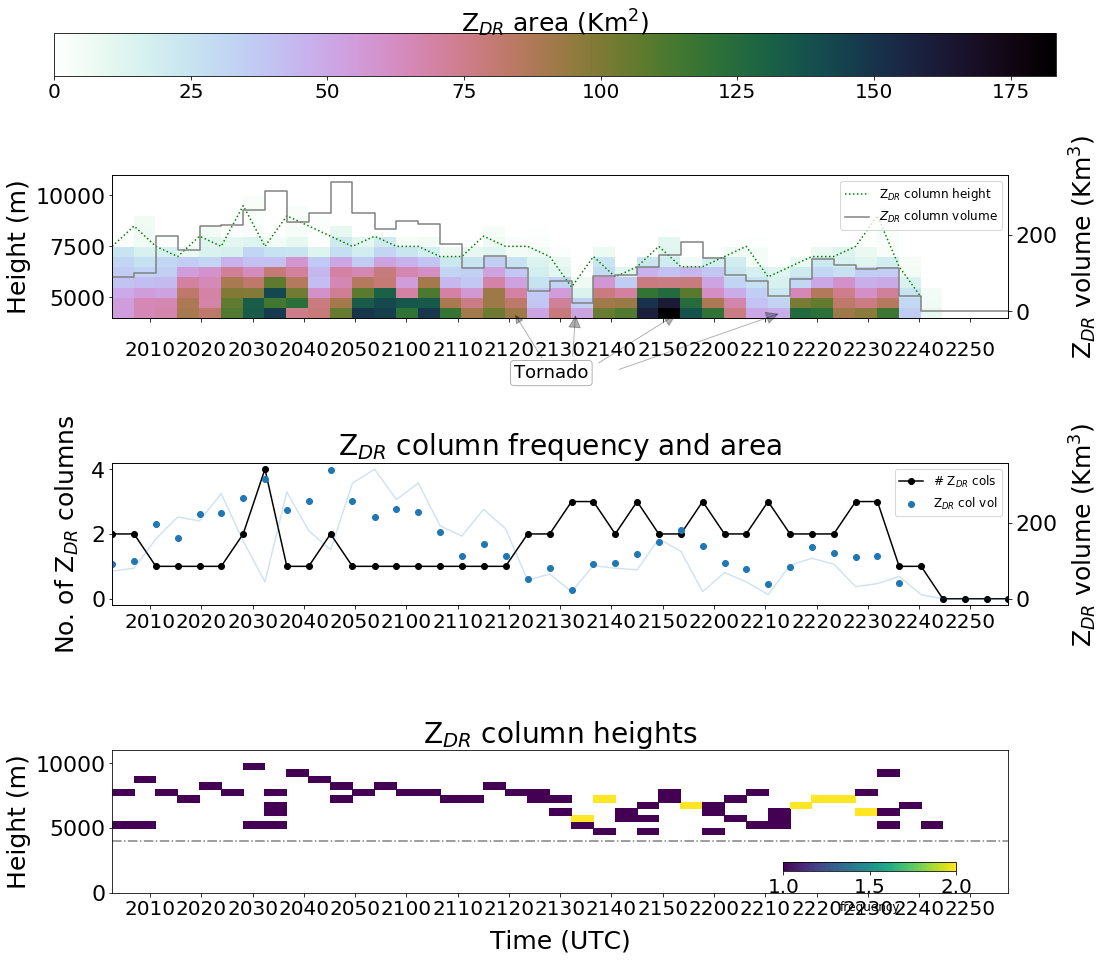

In [17]:
# Manually verified zdr columns and their aggragated volumes for each time step are plotted (if multiple zdr objects present)
# ZDR column is plotted only for the tallest column at that instance in time
# ZDR area is aggregated at each z-level for all time steps if multiple zdr objects are present

base_height = 4000  # this adds 4000 to the zdr column height calculated above so that the overlay of zdr_col_hght looks better

fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(3, 1)
ax = fig.add_subplot(gs[0])
mappable = ax.pcolormesh(
    zdr_area_all_zlevels.columns.values,
    zdr_area_all_zlevels.index.values,
    zdr_area_all_zlevels,
    cmap="cubehelix_r",
)  # plot zdr column area at each zlevel as a pcolormesh in subplot 1
plot1 = ax.plot_date(
    dt_tmpstmps,
    zdr_col_df.max(level="scan") + base_height,
    "g:",
    xdate=True,
    label="Z$_{DR}$ column height",
)  # plot zdr column heights in subplot 1
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H%M"))
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax.set_ylabel("Height (m)")
ax.legend()
ax.tick_params(axis="x", which="major", pad=20)
ax1 = ax.twinx()
with pd.plotting.plot_params.use("x_compat", True):
    # instead of image segmented ZDR volume, let's plot direct array ZDR vol
    plot2 = zdr_vol_ts_new.sum(level="time").plot(
        drawstyle="steps-post", color="gray", ax=ax1, rot=0
    )
    
#     plot2 = zdr_vol_ts.sum(level="time").plot(
#         drawstyle="steps-post", color="gray", ax=ax1, rot=0
#     )  # step line plot for zdr volume in subplot 1
ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H%M"))
ax1.set_ylabel("Z$_{DR}$ volume (Km$^{3}$)", rotation=90, labelpad=10)
cbaxes = fig.add_axes([0.067,1.05, 0.87, 0.05])
cbar = fig.colorbar(mappable, pad=0.15, orientation="horizontal", cax=cbaxes)
cbar.set_label("Z$_{DR}$ area (Km$^{2}$)", labelpad=-95)
ax1.get_legend().remove()
plots = plot1 + plot2.get_lines()
labs = [plot.get_label() for plot in plots]
ax.legend(plots, labs, loc=1, fontsize=12)

my_annotate(
    ax1,
    "Tornado",
    xy_arr=[
        (datetime(2013, 5, 19, 21, 21, 0), -5),
        (datetime(2013, 5, 19, 21, 33, 0), -5),
        (datetime(2013, 5, 19, 21, 53, 0), -5),
        (datetime(2013, 5, 19, 22, 13, 0), -5),
    ],
    xycoords="data",
    xytext=(0, -65),
    textcoords="offset points",
    bbox=dict(boxstyle="round,pad=0.2", fc="w", alpha=0.3),
    arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=0", fc="k", alpha=0.3),
    fontsize=18,
)

ax2 = fig.add_subplot(gs[1], sharex=ax)
plot3 = ax2.plot(
    zdr_area_df.reset_index().groupby("time")["obj_id"].nunique(), "-ko"
)  # line plot for number of zdr columns in subplot 2
ax2.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%H%M"))
ax2.set_ylabel("No. of Z$_{DR}$ columns", rotation=90, labelpad=10)
ax2.margins(x=0)

ax3 = ax2.twinx()
plot4 = ax3.scatter(
    zdr_vol_ts_new.index.get_level_values("time"), zdr_vol_ts_new
)  # scatter plot for zdr column volume in subplot 2
ax3.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%H%M"))
ax3.margins(x=0)
ax3.set_ylabel("Z$_{DR}$ volume (Km$^{3}$)", rotation=90, labelpad=10)

vol_ts = zdr_vol_ts.groupby(
    level=["time"]
).median()  # Calculate median value of zdr col volumes. Note: If I try plotting this directly by appending .plot(...), it messes up the plot xticks
plot5 = ax3.plot(vol_ts, alpha=0.2)  # line plot of median zdr col volume in subplot 2
# with pd.plotting.plot_params.use('x_compat',True):
#     plot5 = zdr_vol_ts.groupby(level=['time']).median().plot(color='blue',ax=ax3,alpha=0.1)   #plot median zdr column volume out of all zdr columns at that time step in subplot 2

ax3.legend(
    [plot3[0], plot4], ["# Z$_{DR}$ cols", "Z$_{DR}$ col vol"], loc=0, fontsize=12
)
ax3.set_title("Z$_{DR}$ column frequency and area")

ax4 = fig.add_subplot(gs[2], sharex=ax)
plot6 = ax4.pcolormesh(
    zdr_freq_final.index.values,
    zdr_freq_final.columns.values + base_height,
    zdr_freq_final.values.astype(float).transpose(),
)  # pcolormesh plot of zdr col height in subplot 3
ax4.hlines(z_start, dt_tmpstmps[0], dt_tmpstmps[-1], linestyle="-.", color="gray")
ax4.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax4.xaxis.set_major_formatter(mdates.DateFormatter("%H%M"))
ax4.set_xlabel("Time (UTC)", labelpad=10)
ax4.set_ylabel("Height (m)")
ax4.set_ylim([0, 11000])
cbaxes_ = fig.add_axes([0.70, 0.13, 0.15, 0.01])
cbar_ = fig.colorbar(plot6, pad=0.15, orientation="horizontal", cax=cbaxes_)
cbar_.set_label("frequency", fontsize=12)
ax4.set_title("Z$_{DR}$ column heights")

plt.tight_layout()
plt.show()

#### STEP 3: Next, we load NLDN and OKLMA data to generate an overlay plot with ZDR column height and volume timeseries, and CG & total lightning flash rates

In [18]:
# Read in NLDN data and filter CG flashes that belong exclusively to the EC storm

file = "../data/interim/051913_NLDN_15kA_filter.txt"

data = pd.read_csv(
    file,
    delim_whitespace=True,
    header=None,
    names=["date", "time", "lat", "lon", "unknown", "Power", "kA", "strokes"],
)

data["datetime"] = data["date"] + " " + data["time"]

data.index = data["datetime"]
data.index = pd.to_datetime(data["datetime"])

data = data.drop(columns=["date", "time", "datetime"])

df2 = data[~((data["Power"] > -15) & (data["Power"] < 15))]

df3 = df2["2013-05-19 20:00:00":"2013-05-19 22:30:00"]

one_p = df3["2013-05-19 20:00:00":"2013-05-19 20:09:59"]
one_p_ = one_p[
    (
        (one_p["lon"] > -98.1)
        & (one_p["lon"] < -97.6)
        & (one_p["lat"] > 35.35)
        & (one_p["lat"] < 35.8)
    )
]

one_q = df3["2013-05-19 20:10:00":"2013-05-19 20:19:59"]
one_q_ = one_q[
    (
        (one_q["lon"] > -98)
        & (one_q["lon"] < -97.3)
        & (one_q["lat"] > 35.35)
        & (one_q["lat"] < 35.8)
    )
]

one_r = df3["2013-05-19 20:20:00":"2013-05-19 20:29:59"]
one_r_ = one_r[
    (
        (one_r["lon"] > -98)
        & (one_r["lon"] < -97.3)
        & (one_r["lat"] > 35.35)
        & (one_r["lat"] < 35.8)
    )
]

one = df3["2013-05-19 20:30:00":"2013-05-19 20:39:59"]
one_ = one[
    (
        (one["lon"] > -97.9)
        & (one["lon"] < -97.2)
        & (one["lat"] > 35.4)
        & (one["lat"] < 35.9)
    )
]

two = df3["2013-05-19 20:40:00":"2013-05-19 20:49:59"]
two_ = two[
    (
        (two["lon"] > -97.8)
        & (two["lon"] < -97.1)
        & (two["lat"] > 35.45)
        & (two["lat"] < 36)
    )
]

three = df3["2013-05-19 20:50:00":"2013-05-19 20:59:59"]
three_ = three[
    (
        (three["lon"] > -97.75)
        & (three["lon"] < -97.1)
        & (three["lat"] > 35.45)
        & (three["lat"] < 36)
    )
]

four = df3["2013-05-19 21:00:00":"2013-05-19 21:09:59"]
four_ = four[
    (
        (four["lon"] > -97.8)
        & (four["lon"] < -97.1)
        & (four["lat"] > 35.4)
        & (four["lat"] < 36)
    )
]

five = df3["2013-05-19 21:10:00":"2013-05-19 21:19:59"]
five_ = five[
    (
        (five["lon"] > -97.7)
        & (five["lon"] < -96.8)
        & (five["lat"] > 35.5)
        & (five["lat"] < 36)
    )
]

six = df3["2013-05-19 21:20:00":"2013-05-19 21:29:59"]
six_ = six[
    (
        (six["lon"] > -97.6)
        & (six["lon"] < -96.8)
        & (six["lat"] > 35.5)
        & (six["lat"] < 36)
    )
]

seven = df3["2013-05-19 21:30:00":"2013-05-19 21:39:59"]
seven_ = seven[
    (
        (seven["lon"] > -97.6)
        & (seven["lon"] < -96.8)
        & (seven["lat"] > 35.5)
        & (seven["lat"] < 36.1)
    )
]

eight = df3["2013-05-19 21:40:00":"2013-05-19 21:49:59"]
eight_ = eight[
    (
        (eight["lon"] > -97.5)
        & (eight["lon"] < -96.6)
        & (eight["lat"] > 35.5)
        & (eight["lat"] < 36.2)
    )
]

nine = df3["2013-05-19 21:50:00":"2013-05-19 21:59:59"]
nine_ = nine[
    (
        (nine["lon"] > -97.4)
        & (nine["lon"] < -96.6)
        & (nine["lat"] > 35.55)
        & (nine["lat"] < 36.1)
    )
]

ten = df3["2013-05-19 22:00:00":"2013-05-19 22:09:59"]
ten_ = ten[
    (
        (ten["lon"] > -97.15)
        & (ten["lon"] < -96.6)
        & (ten["lat"] > 35.62)
        & (ten["lat"] < 36.1)
    )
]

eleven = df3["2013-05-19 22:10:00":"2013-05-19 22:19:59"]
eleven_ = eleven[
    (
        (eleven["lon"] > -97.25)
        & (eleven["lon"] < -96.75)
        & (eleven["lat"] > 35.63)
        & (eleven["lat"] < 36.1)
    )
]

twelve = df3["2013-05-19 22:20:00":"2013-05-19 22:29:59"]
twelve_ = twelve[
    (
        (twelve["lon"] > -97)
        & (twelve["lon"] < -96.5)
        & (twelve["lat"] > 35.62)
        & (twelve["lat"] < 36.1)
    )
]


final_data = pd.concat(
    [
        one_p_,
        one_q_,
        one_r_,
        one_,
        two_,
        three_,
        four_,
        five_,
        six_,
        seven_,
        eight_,
        nine_,
        ten_,
        eleven_,
        twelve_,
    ]
)


total = final_data.index.value_counts().sort_index()
total1 = total.resample("Min").agg({"sum"})

positive = final_data[(final_data["Power"] > 0)]
pos = positive.index.value_counts().sort_index()
pos1 = pos.resample("Min").agg({"sum"})

negative = final_data[(final_data["Power"] < 0)]
neg = negative.index.value_counts().sort_index()
neg1 = neg.resample("Min").agg({"sum"})

# create datetime stamps for missing timesteps and fill those indices with zero flash count
missing_idx = pd.date_range("2013-05-19 20:00:00", "2013-05-19 22:30:00", freq="min")
total1 = total1.reindex(missing_idx, fill_value=0)
pos1 = pos1.reindex(missing_idx, fill_value=0)
neg1 = neg1.reindex(missing_idx, fill_value=0)


###### Load and plot data from lasso analysis generated flash stats csv file

lasso = "../data/interim/flash_stats.csv"

lasso_data = pd.read_csv(lasso, usecols=[0, 2])
lasso_data = lasso_data[0:-1]
lasso_data.columns = ["time", "number"]

lasso_data.index = pd.to_datetime(lasso_data["time"])
lasso_data = lasso_data.drop(columns=["time"])

#### STEP 4: Calculate of correlation coefficients and rolling mean for plotting time series overlay plots

In [19]:
# convert lma data timestamps to strings to plot them on x-axis in our plot
time_lma = lasso_data.index

final_time_lma = []
for i in range(len(time_lma)):
    final_time_lma.append(datetime.strptime(str(time_lma[i]), "%Y-%m-%d %H:%M:%S"))

In [20]:
# Now, we resample our lightning flash rate data to be able to correlate it with the ZDR column height time series
# Note that in order to compare two different dataframes, their columns names should be same which has been done below

resampled_lma = lasso_data.reindex(
    dt_tmpstmps, method="ffill", index=None, columns=None
)
resampled_lma.columns = [""]

zdr_hght_ts = pd.DataFrame(zdr_col_df["zdr_col_height"].max(level="scan"))
zdr_hght_ts.columns = [""]

In [21]:
# This is to calculate flash rate at the same time as radar derived ZDR column height
# so that we can calculate the correlation coefficient between these two variables

r_pearson_hgt = zdr_hght_ts.max(level="scan").corrwith(
    resampled_lma, axis=0, method="spearman"
)
rho_spearman_hgt = zdr_hght_ts.max(level="scan").corrwith(
    resampled_lma, axis=0, method="pearson"
)

print(
    f"Pearson correlation coefficient for max zdr col height and lightning flash rates is {r_pearson_hgt[0]}"
)
print(
    f"Spearman correlation coefficient for max zdr col height and lightning flash rates is {rho_spearman_hgt[0]}"
)

Pearson correlation coefficient for max zdr col height and lightning flash rates is 0.46935054110145435
Spearman correlation coefficient for max zdr col height and lightning flash rates is 0.46644872997784714


In [22]:
# Calculate 5 window rolling mean for zdr column heights

final_mvg_avg = zdr_hght_ts.rolling(window=5).mean()
final_mvg_avg_KTLX = final_mvg_avg.shift(-2)

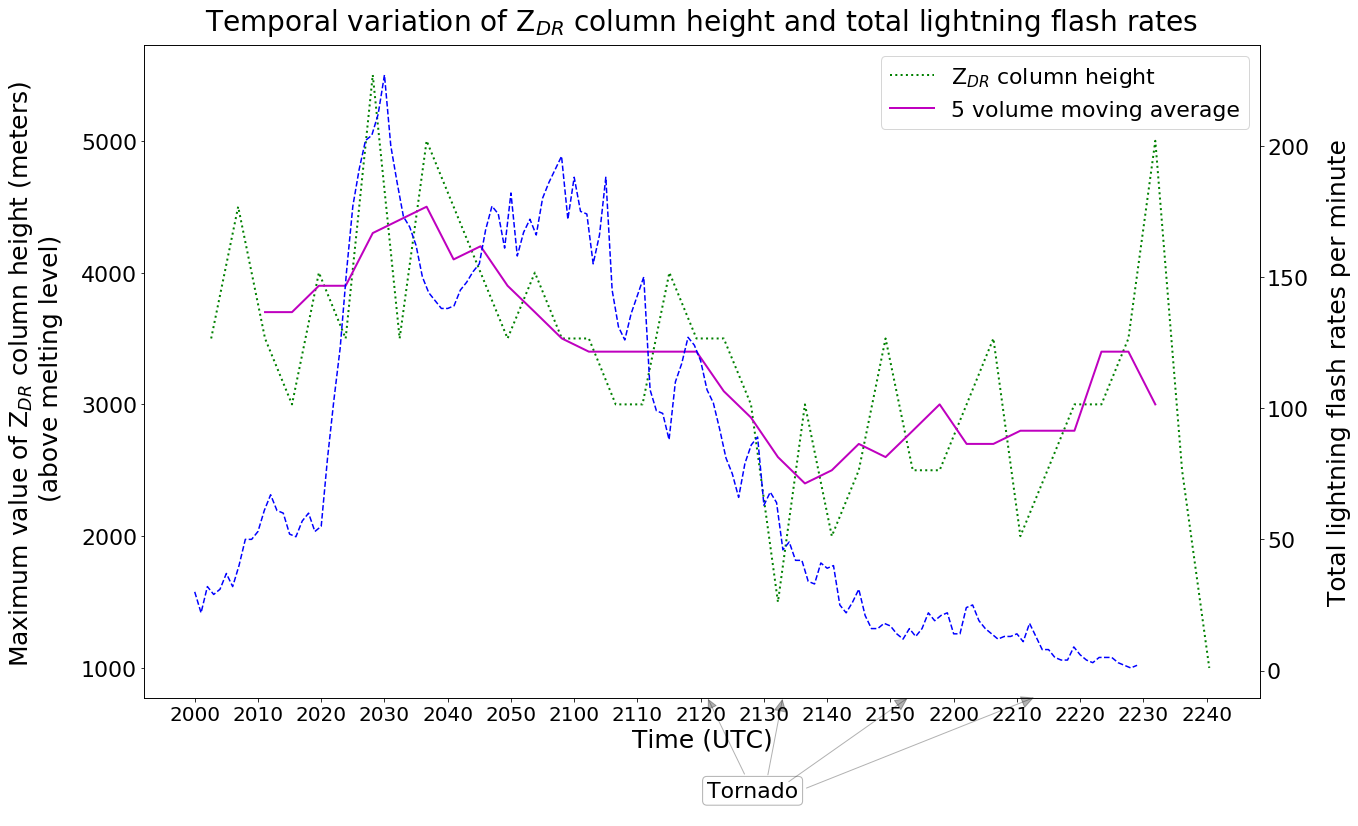

In [23]:
# Plot ZDR column height time series overlaid with lightning flash rates and rolling mean

fig, ax = plt.subplots(figsize=(20, 12))
hplot1 = ax.plot_date(
    dt_tmpstmps, zdr_hght_ts, "g:", lw=2, xdate=True, label="Z$_{DR}$ column height"
)
hplot2 = ax.plot_date(
    final_mvg_avg.index,
    final_mvg_avg_KTLX.values,
    "m-",
    xdate=True,
    lw=2,
    label="5 volume moving average",
)
ax.set_ylabel(
    "Maximum value of Z$_{DR}$ column height (meters) \n (above melting level)",
    labelpad=18,
)
ax.set_xlabel("Time (UTC)")
ax1 = ax.twinx()
ax1.plot_date(
    final_time_lma,
    lasso_data["number"].values,
    "b--",
    xdate=True,
    label="total flash rate (flashes/min)",
)
ax1.set_ylabel("Total lightning flash rates per minute", labelpad=18,fontsize=25)
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H%M"))
hplots = hplot1 + hplot2
hlabs = [plot.get_label() for plot in hplots]
ax.legend(hplots, hlabs, loc="best",fontsize=22)
plt.title(
    "Temporal variation of Z$_{DR}$ column height and total lightning flash rates",
    pad=15,
)

my_annotate(
    ax1,
    "Tornado",
    xy_arr=[
        (datetime(2013, 5, 19, 21, 21, 0), -10),
        (datetime(2013, 5, 19, 21, 33, 0), -10),
        (datetime(2013, 5, 19, 21, 53, 0), -10),
        (datetime(2013, 5, 19, 22, 13, 0), -10),
    ],
    xycoords="data",
    xytext=(0, -100),
    textcoords="offset points",
    bbox=dict(boxstyle="round,pad=0.2", fc="w", alpha=0.3),
    arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=0", fc="k", alpha=0.3),
    fontsize=22,
)

plt.show()

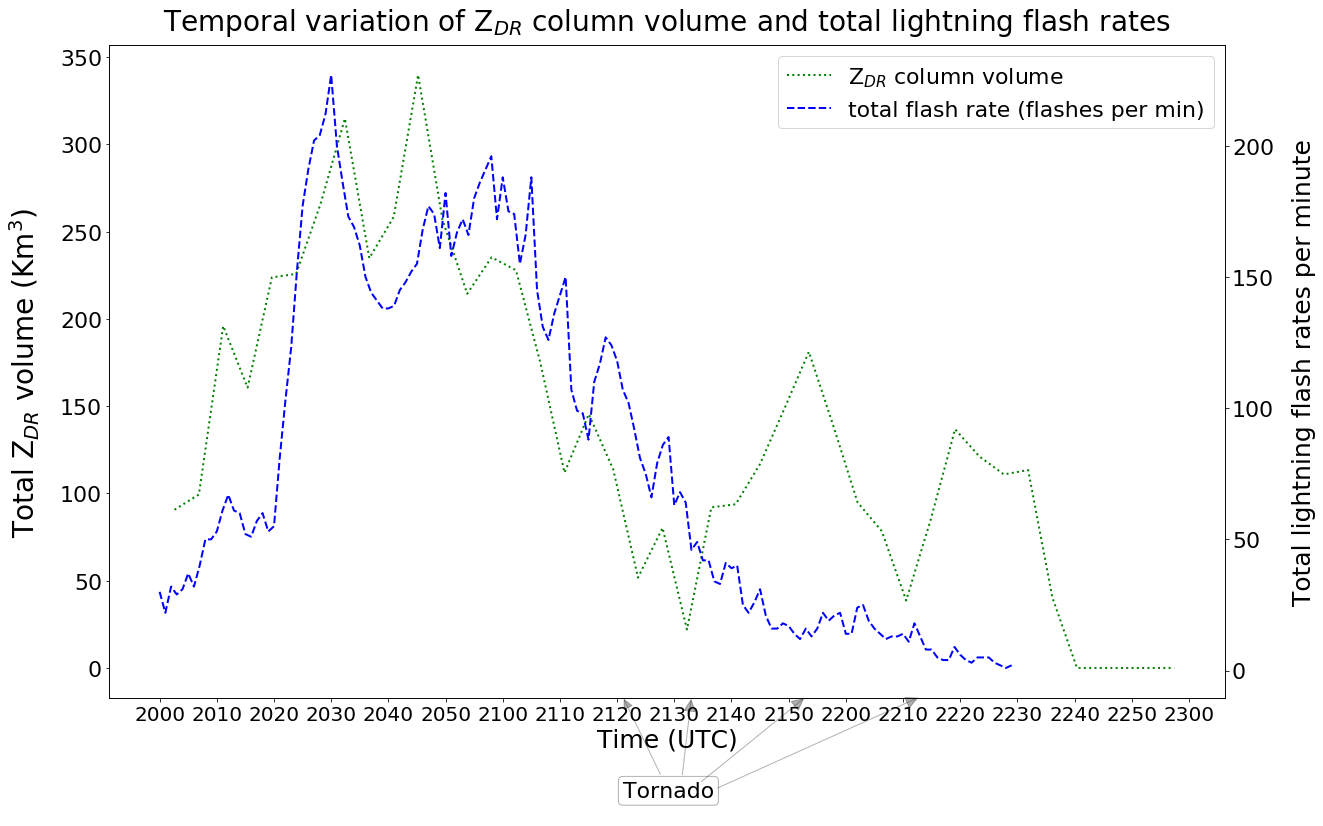

In [24]:
# Next, plot total ZDR column volume (sum of all legit ZDR objects at a time step) time series overlaid with lightning flash rates

fig, ax = plt.subplots(figsize=(20, 12))
vplot1 = ax.plot_date(
    dt_tmpstmps,
    zdr_vol_ts_new.sum(level="time"),
    "g:",
    xdate=True,
    lw=2,
    label="Z$_{DR}$ column volume",
)
ax.set_ylabel("Total Z$_{DR}$ volume (Km$^{3}$)", labelpad=18,fontsize=28)
ax.set_xlabel("Time (UTC)")
ax1 = ax.twinx()
vplot2 = ax1.plot_date(
    final_time_lma,
    lasso_data["number"].values,
    "b--",
    xdate=True,
    lw=2,
    label="total flash rate (flashes per min)",
)
ax1.set_ylabel("Total lightning flash rates per minute", labelpad=18)
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H%M"))
vplots = vplot1 + vplot2
vlabs = [plot.get_label() for plot in vplots]
ax.legend(vplots, vlabs, loc="best",fontsize=22)
plt.title(
    "Temporal variation of Z$_{DR}$ column volume and total lightning flash rates",
    pad=15
)

my_annotate(
    ax1,
    "Tornado",
    xy_arr=[
        (datetime(2013, 5, 19, 21, 21, 0), -10),
        (datetime(2013, 5, 19, 21, 33, 0), -10),
        (datetime(2013, 5, 19, 21, 53, 0), -10),
        (datetime(2013, 5, 19, 22, 13, 0), -10),
    ],
    xycoords="data",
    xytext=(0, -100),
    textcoords="offset points",
    bbox=dict(boxstyle="round,pad=0.2", fc="w", alpha=0.3),
    arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=0", fc="k", alpha=0.3),
    fontsize=22,
)

plt.show()

In [25]:
# correlation between zdr vol total and lightning flash rates

zdr_vol_tsc = zdr_vol_ts_new.copy()
zdr_vol_tsc.columns = [""]

r_pearson_vol = zdr_vol_tsc.sum(level="time").corrwith(
    resampled_lma, axis=0, method="spearman"
)
rho_spearman_vol = zdr_vol_tsc.sum(level="time").corrwith(
    resampled_lma, axis=0, method="pearson"
)

print(
    f"Pearson correlation coefficient for zdr volume and lightning flash rates is {r_pearson_vol[0]}"
)
print(
    f"Spearman correlation coefficient for zdr volume and lightning flash rates is {rho_spearman_vol[0]}"
)

Pearson correlation coefficient for zdr volume and lightning flash rates is 0.7398301418505681
Spearman correlation coefficient for zdr volume and lightning flash rates is 0.7584757748589953


In [26]:
# calculate Spearman corr coefficient till 2130 UTC only to avoid that peak later

zdr_vol_tsc.sum(level="time")[0:22].corrwith(
    resampled_lma[0:22], axis=0, method="spearman"
)

    0.707145
dtype: float64

In [27]:
# define lagged cross correlation function to check for maximum correlation and its lag


def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corrwith(datay.shift(lag), axis=0, method="pearson")

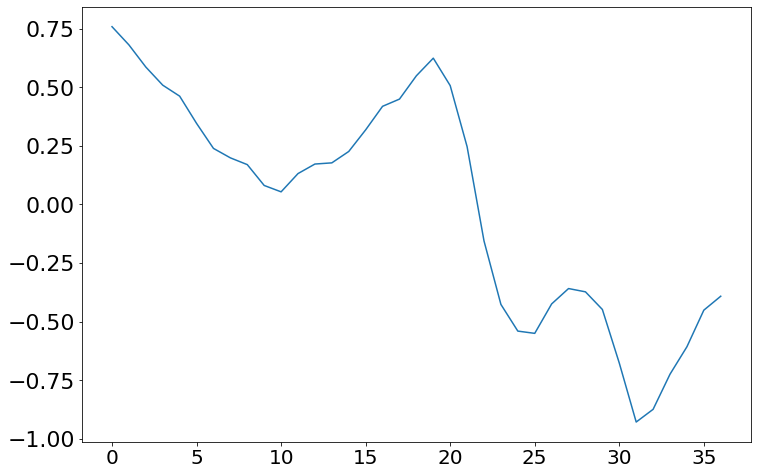

In [28]:
lagged_corr_zdr = [
    crosscorr(zdr_vol_tsc.sum(level="time"), resampled_lma, lag=i)
    for i in range(len(resampled_lma))
]

plt.plot(lagged_corr_zdr)

In [29]:
lagged_corr_zdr = np.asarray(
    lagged_corr_zdr
)  # convert lagged_corr_zdr from list to numpy array
max_corr_zdr_t = np.nanargmax(
    lagged_corr_zdr
)  # calculate the index at which the array lagged_corr_zdr attains maxima
t_zdr_corr_max = dt_tmpstmps[
    max_corr_zdr_t
]  # time corresponding to zdr_col_volume and lightning flash rates  cross correlation being maximum

delay_zdr_corr = t_zdr_corr_max - dt_tmpstmps[0]
delay_zdr_corr.total_seconds() / 3600  # total delay in hours

0.0

In [30]:
# Load the saved dataframe for plotting time vs altitude plot of flash initiations

# These initiations correspond only to those regions which coincide within the identified ZDR objects
# Since our conventional tiff image reading approach through AICSImage was not suitable, this dataset/dataframe
# was actually created using the direct numpy array corresponding to segemnted images
# refer segmented_from_grid_array_zdr.ipynb for more details

ini_df = pd.read_csv(
    os.path.expanduser(
        "../data/interim/zdr_col_analysis/flash_initiation_data_within_zdr_col_region/time_alt_ini.txt"
    ),
    sep="\t",
)
ini_df.index = ini_df["Unnamed: 0"]
ini_df = ini_df.drop(labels=["Unnamed: 0"], axis=1)
ini_df.columns = pd.to_datetime(ini_df.columns)

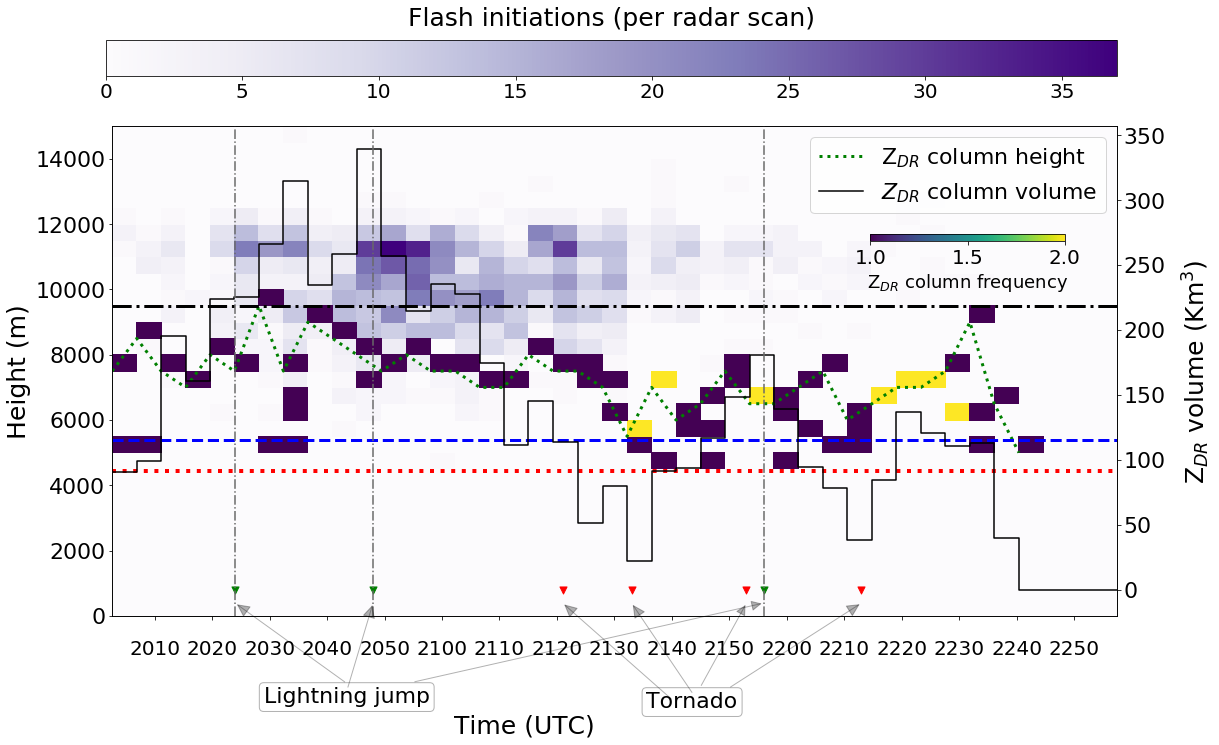

In [34]:
### Manually verified zdr columns and their aggragated volumes for each time step are plotted (if multiple zdr objects present)
# ZDR column is plotted only for the tallest column at that instance in time
# ZDR area is aggregated at each z-level for all time steps if multiple zdr objects are present

base_height = 4000  # this adds 4000 to the zdr column height calculated above so that the overlay of zdr_col_hght looks better

fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0])
mappable = ax.pcolormesh(
    ini_df.columns.values, ini_df.index.values, ini_df, cmap="Purples"
)  # plot zdr column area at each zlevel as a pcolormesh in subplot 1
plot1 = ax.plot_date(
    dt_tmpstmps,
    zdr_col_df.max(level="scan") + base_height,
    "g:",
    xdate=True,
    lw=3,
    label="Z$_{DR}$ column height",
)  # plot zdr column heights in subplot 1
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H%M"))
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax.set_ylabel("Height (m)")
ax.set_xlabel("Time (UTC)", labelpad=44)
ax.xaxis.set_label_coords(0.41, -0.2)

ax.legend()
ax.tick_params(axis="x", which="major", pad=20)
ax1 = ax.twinx()
with pd.plotting.plot_params.use("x_compat", True):
    plot2 = zdr_vol_ts_new.sum(level="time").plot(
        drawstyle="steps-post", color="k", ax=ax1, rot=0
    )  # step line plot for zdr volume in subplot 1

ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H%M"))
ax1.set_ylabel("Z$_{DR}$ volume (Km$^{3}$)", labelpad=15)
cbaxes = fig.add_axes([0.12, 0.95, 0.78, 0.05])
cbar = fig.colorbar(mappable, pad=0.15, orientation="horizontal", cax=cbaxes)
cbar.set_label("Flash initiations (per radar scan)", fontsize=25, labelpad=-95)
ax1.get_legend().remove()
plots = plot1 + plot2.get_lines()
labs = [plot.get_label() for plot in plots]
ax.legend(plots, labs, loc=0, fontsize=22)

plot6 = ax.pcolormesh(
    zdr_freq_final.index.values,
    zdr_freq_final.columns.values + base_height,
    zdr_freq_final.values.astype(float).transpose(),
)  # pcolormesh plot of zdr col height in subplot 3
cbaxes_ = fig.add_axes([0.71, 0.72, 0.15, 0.01])
cbar_ = fig.colorbar(plot6, pad=0.16, orientation="horizontal", cax=cbaxes_)
cbar_.set_label("Z$_{DR}$ column frequency", fontsize=18)
# plt.setp(ax1.get_xticklabels(), visible=False)
# plt.setp(ax.get_xticklabels(), visible=False)

# add tornado reports on x-axis
ax1.scatter(datetime(2013, 5, 19, 21, 21, 0), 0, marker="v", s=50, c="r")
ax1.scatter(datetime(2013, 5, 19, 21, 33, 0), 0, marker="v", s=50, c="r")
ax1.scatter(datetime(2013, 5, 19, 21, 53, 0), 0, marker="v", s=50, c="r")
ax1.scatter(datetime(2013, 5, 19, 22, 13, 0), 0, marker="v", s=50, c="r")

# add lightning jump times
ax1.scatter(datetime(2013, 5, 19, 20, 24, 0), 0, marker="v", s=50, c="g")
ax1.scatter(datetime(2013, 5, 19, 20, 48, 0), 0, marker="v", s=50, c="g")
ax1.scatter(datetime(2013, 5, 19, 21, 56, 0), 0, marker="v", s=50, c="g")

ax1.axvline(datetime(2013, 5, 19, 20, 24, 0), linestyle="-.", color="dimgrey")
ax1.axvline(datetime(2013, 5, 19, 20, 48, 0), linestyle="-.", color="dimgrey")
ax1.axvline(datetime(2013, 5, 19, 21, 56, 0), linestyle="-.", color="dimgrey")

my_annotate(
    ax1,
    "Tornado",
    xy_arr=[
        (datetime(2013, 5, 19, 21, 53, 0), -10),
        (datetime(2013, 5, 19, 22, 13, 0), -10),
        (datetime(2013, 5, 19, 21, 33, 0), -10),
        (datetime(2013, 5, 19, 21, 21, 0), -10),
    ],
    xycoords="data",
    xytext=(-100, -105),
    textcoords="offset points",
    bbox=dict(boxstyle="round,pad=0.2", fc="w", alpha=0.3),
    arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=0", fc="k", alpha=0.3),
    fontsize=22,
)

my_annotate(
    ax1,
    "Lightning jump",
    xy_arr=[
        (datetime(2013, 5, 19, 21, 56, 0), -10),
        (datetime(2013, 5, 19, 20, 24, 0), -10),
        (datetime(2013, 5, 19, 20, 48, 0), -10),
    ],
    xycoords="data",
    xytext=(-500, -100),
    textcoords="offset points",
    bbox=dict(boxstyle="round,pad=0.2", fc="w", alpha=0.3),
    arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=0", fc="k", alpha=0.3),
    fontsize=22,
)

ax.axhline(y=4436,linestyle='dotted',linewidth=4,c='r',label='0$^{\circ}$C')
ax.axhline(y=5376,linestyle='dashed',linewidth=3,c='b',label='-10$^{\circ}$C')
ax.axhline(y=9490,linestyle='dashdot',linewidth=3,c='k',label='-40$^{\circ}$C')

# plt.tight_layout()
# plt.savefig('/Users/ms/Desktop/mount/May_19_2013_all_stuff/plots_LMA_May19_2013/manuscript_figures/individual_plots_for_panel_figures/zdr_kdp_vol_init_per_radar_scan/ZDR_col_vol_initiations_per_radar_scan1.png',
#            dpi=300,bbox_inches='tight')
plt.show()

#### STEP 5: Repeat similar analysis for KDP columns as well

In [35]:
# Load the saved dataframe for plotting time vs altitude plot of flash initiations

# These initiations correspond only to those regions which coincide within the identified ZDR objects
# Since our conventional tiff image reading approach through AICSImage was not suitable, this dataset/dataframe
# was actually created using the direct numpy array corresponding to segemnted images
# refer segmented_from_grid_array_zdr.ipynb for more details

ini_df = pd.read_csv(
    os.path.expanduser(
        "../data/interim/kdp_analysis/flash_initiation_data_within_kdp_col_region/time_alt_ini.txt"
    ),
    sep="\t",
)
ini_df.index = ini_df["Unnamed: 0"]
ini_df = ini_df.drop(labels=["Unnamed: 0"], axis=1)
ini_df.columns = pd.to_datetime(ini_df.columns)

In [36]:
# after manual verification of all the KDP column objects at the 4km level, we list out the ones that are embedded within Edmond-Carney storm
# This should filter out artifacts (due to gridding or contamination from nearby storms)
# each list within the obj_interest list specifies the object labels that are of our interest.
# There are 42 such lists in obj_interest corresponding to all the times for which we have gridded radar data
# The first eleven entries are nan because there was no realistic KDP object detected (at least did not appear so to my eye)

obj_interest = [
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [1],
    [1],
    [6],
    [1],
    [1],
    [1],
    [1],
    [1],
    [2],
    [1],
    [1],
    [1],
    [2],
    [1],
    [1, 2, 3],
    [1, 3],
    [1, 2],
    [1],
    [1],
    [1],
    [1],
    [1],
    [1],
    [1],
    [1],
    [1],
    [1],
    [1],
    [1],
    [1],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
]

In [37]:
# Here we load the segmentation output files and get datetime objects for each time step from radar files

segmented_files = sorted(glob.glob("../data/processed/segmented_stacks/kdp/img_format/*.tiff"))

# segmented_kdp_files = sorted(glob.glob("../data/processed/segmented_stacks/kdp/img_format/*.tiff"))

In [38]:
# Here, we create a multiindexed dataframe for storing kdp colmn heights at each time step
kdp_col_df = pd.DataFrame()
for i in range(len(segmented_files)):
    cell_seg_reader = AICSImage(segmented_files[i])
    cell_seg = cell_seg_reader.data[0, 0, :, :, :]

    tmp_df = kdp_col_hght(cell_seg, i,obj_interest)
    kdp_col_df = kdp_col_df.append(tmp_df)

In [39]:
# These are from new segmentation performed on kdp array on Nov 28, 2020
kdp_obj_interest = [
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [8],
    [4],
    [7],
    [3, 8],
    [3],
    [4],
    [3],
    [2],
    [4, 6],
    [2],
    [1],
    [2],
    [5],
    [5],
    [2, 3],
    [4],
    [4],
    [2],
    [1],
    [2],
    [3, 4],
    [2],
    [3, 4],
    [3],
    [3],
    [1],
    [1],
    [1],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
]

In [40]:
nan_idx = [i for i, el in enumerate(kdp_obj_interest) if np.nan in el]

In [41]:
kdp_vol_ts_new = pd.read_csv('../data/processed/segmented_stacks/kdp/kdp_vol_gt_0.75degkm_pyart_based_segmentation')
kdp_vol_ts_new = kdp_vol_ts_new.set_index('time')
kdp_vol_ts_new.index = pd.to_datetime(kdp_vol_ts_new.index)
kdp_vol_ts_new = kdp_vol_ts_new.rename({'vol':'$K_{DP}$ column volume'},axis=1)

In [42]:
tmp_kdp_vol_ts_new = pd.DataFrame(np.nan, index=[dt_tmpstmps[dt] for dt in nan_idx], columns=['$K_{DP}$ column volume'])
tmp_kdp_vol_ts_new.index.name = 'time'

kdp_vol_ts_new = kdp_vol_ts_new.append(tmp_kdp_vol_ts_new)
kdp_vol_ts_new = kdp_vol_ts_new.reindex(labels=dt_tmpstmps)

In [43]:
# Since I had manually edited and removed some of the pixels mmisclassified as KDP column using napari and I don't want to repeat the process every time
# At the time of classification, I had saved the results into text files which can be loaded back here to calculate our statistics
# This way our calculations will be consistent and reproducible however many time we want to run this piece of code

df = pd.read_csv(
    "../data/interim/kdp_analysis/df_mega_dict_kdp_case_after_label_editing",
    header=0,
    delimiter="\t",
    usecols=None,
    engine="python",
)

df = df.drop(labels=["Unnamed: 0"], axis=1)
df.columns = [""] * len(df.columns)
df.index = [""] * len(df.index)

df1 = df.applymap(lambda x: x.strip() if type(x) == str else x)
dd = [eval(ele) for a in df1.values.tolist() for ele in a]

mega_dict = np.reshape(dd, [42, 15])

In [44]:
# Create a dataframe is to extract a list of lists corresponding to each time step and all labeled objects at that time step

full_list_areas = []
for k in range(len(mega_dict)):
    tt1 = [d["label"] for d in mega_dict[k] if "label" in d]
    tt2 = [d["area"] for d in mega_dict[k] if "area" in d]

    objs = obj_interest[k]
    all_areas = []
    for m in range(len(objs)):
        obj_id = objs[m]
        areas = []
        for i in range(len(tt1)):
            if obj_id in tt1[i]:
                for j in range(len(tt1[i])):
                    if tt1[i][j] == obj_id:
                        areas.append(tt2[i][j])
            else:
                areas.append(0)

        if len(areas) < 15:
            N = 15 - len(areas)
            areas = np.pad(areas, (0, N), "constant")

        all_areas.append(areas)
    full_list_areas.append(all_areas)

In [45]:
# Now that we have a means to extract info for each object and its area at each z-level,  we proceed with creating a hierarchical index pandas dataframe

z_start = 4000
z_end = 11000
dz = 500

zlevels = np.arange(z_start, z_end + dz, dz)
kdp_area_df = pd.DataFrame()
for i in range(len(full_list_areas)):  # loop over all the time steps
    for j in range(len(obj_interest[i])):  # loop over all objects at a time step
        tm = dt_tmpstmps[i]
        lb = obj_interest[i][j]
        tf = pd.DataFrame(data=full_list_areas[i][j]).transpose()
        tf.index = pd.MultiIndex.from_arrays([[tm], [lb]], names=["time", "obj_id"])
        kdp_area_df = kdp_area_df.append(tf)
kdp_area_df.columns = zlevels  # assign z-levels as column names to our dataframe

In [46]:
# A multiindexed dataframe gives us enough flexibilty to perofrm further operations
# for example, we can use aggregation methods to calculate total area at each z-level and time step (and eventually plot a pcolormesh plot)

# we can also sum up areas of all objects at all z-levels at a particular time step to calculate volume of KDP objects


# Let's calculate aggregated (sum of all objects; if #obj > 1) kdp area at each z-level first


kdp_area_all_zlevels = (
    kdp_area_df.sum(level="time").transpose() * x_resolution * y_resolution
)

# Now, let's calculate kdp volume at each time step

kdp_vol_ts = (
    kdp_area_df.sum(axis=1) * x_resolution * y_resolution * z_resolution / 1000.0
)  # Perform pixel to physical distance conversion to calculate the KDP object volume in km3

kdp_vol_ts = pd.DataFrame(kdp_vol_ts, columns=["total_kdp_col_volume"])

In [47]:
## Next, we need to write some extra code to obtain a dataframe that contains kdp column height frequency info

# We do some more jugglery to create a dataframe that can store the frequency of kdp col heights at each time step and zlevel
# We then plot that dataframe to get a plot similar to Fig. 4d in Walqui et al. (2016)

kdp_df_copy = kdp_col_df.copy()
kdp_df_copy = kdp_df_copy.set_index(
    [kdp_df_copy.index.get_level_values("scan"), kdp_df_copy["kdp_col_height"]]
)

kdp_df_copy["col_hght"] = kdp_df_copy["kdp_col_height"].values

kdp_df_copy = kdp_df_copy.drop(columns="kdp_col_height")

# calculate the frequency of heights of kdp column at each time step
kdp_freq = kdp_df_copy.groupby(["scan", "kdp_col_height"]).size()

# transform the frequency series obtained in last step to a dataframe and add columns for further processing
kdp_freq = pd.DataFrame(kdp_freq)
kdp_freq["heights"] = kdp_freq.index.get_level_values("kdp_col_height")
kdp_freq["dates"] = kdp_freq.index.get_level_values("scan")
kdp_freq = kdp_freq.rename(columns={0: "freq"})

# create an empty dataframe kdp_freq_final because we need a 2d array to plot a pcolormesh figure
# the idea is to fill up this dataframe by extracting info from our frequency dataframe 'kdp_freq' above
col_names_kdp_freq = np.arange(z_start, z_end + dz, dz)
tmpstmps_kdp_freq = dt_tmpstmps

kdp_freq_final = pd.DataFrame(index=tmpstmps_kdp_freq, columns=col_names_kdp_freq)

# this is how we iterate through each time stamp index and extract the frequency for each zlevel at that time step to store in kdp_freq_final
for i, row in kdp_freq.iterrows():
    freq = row["freq"]
    hght = row["heights"]
    date = row["dates"]

    kdp_freq_final.at[date, hght] = freq

# the columns of our kdp_freq_final appear jumbled up so we sort the column names (easy to sort because they are just numbers)
kdp_freq_final = kdp_freq_final.reindex(sorted(kdp_freq_final.columns), axis=1)

/Users/ms/anaconda3/envs/segmentation/lib/python3.6/site-packages/ipykernel_launcher.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


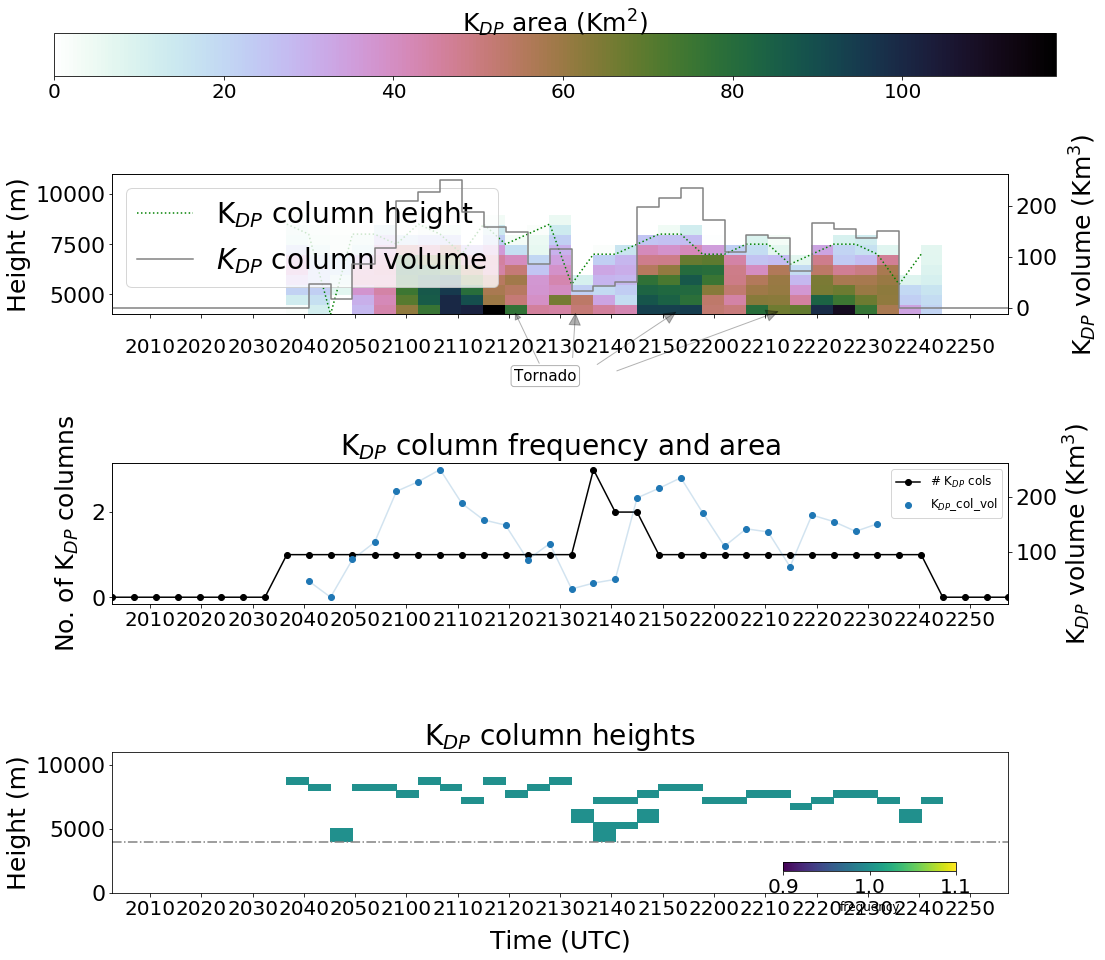

In [48]:
# Manually verified kdp columns and their aggragated volumes for each time step are plotted (if multiple kdp objects present)
# KDP column is plotted only for the tallest column at that instance in time
# KDP area is aggregated at each z-level for all time steps if multiple kdp objects are present

base_height = 4000  # this adds 4000 to the kdp column height calculated above so that the overlay of kdp_col_hght looks better

fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(3, 1)
ax = fig.add_subplot(gs[0])
mappable = ax.pcolormesh(
    kdp_area_all_zlevels.columns.values,
    kdp_area_all_zlevels.index.values,
    kdp_area_all_zlevels,
    cmap="cubehelix_r",
)  # plot kdp column area at each zlevel as a pcolormesh in subplot 1
plot1 = ax.plot_date(
    dt_tmpstmps,
    kdp_col_df.max(level="scan") + base_height,
    "g:",
    xdate=True,
    label="K$_{DP}$ column height",
)  # plot kdp column heights in subplot 1
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H%M"))
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax.set_ylabel("Height (m)")
ax.legend()
ax.tick_params(axis="x", which="major", pad=20)
ax1 = ax.twinx()
with pd.plotting.plot_params.use("x_compat", True):
    plot2 = kdp_vol_ts_new.sum(level="time").plot(
        drawstyle="steps-post", color="gray", ax=ax1, rot=0
    )  # step line plot for kdp volume in subplot 1
ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H%M"))
ax1.set_ylabel("K$_{DP}$ volume (Km$^{3}$)", rotation=90, labelpad=10)
cbaxes = fig.add_axes([0.067, 1.05, 0.87, 0.05])
cbar = fig.colorbar(mappable, pad=0.15, orientation="horizontal", cax=cbaxes)
cbar.set_label("K$_{DP}$ area (Km$^{2}$)", labelpad=-95)
ax1.get_legend().remove()
plots = plot1 + plot2.get_lines()
labs = [plot.get_label() for plot in plots]
ax.legend(plots, labs, loc=0)


my_annotate(
    ax1,
    "Tornado",
    xy_arr=[
        (datetime(2013, 5, 19, 21, 21, 0), -5),
        (datetime(2013, 5, 19, 21, 33, 0), -5),
        (datetime(2013, 5, 19, 21, 53, 0), -5),
        (datetime(2013, 5, 19, 22, 13, 0), -5),
    ],
    xycoords="data",
    xytext=(0, -70),
    textcoords="offset points",
    bbox=dict(boxstyle="round,pad=0.2", fc="w", alpha=0.3),
    arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=0", fc="k", alpha=0.3),
    fontsize=15,
)

ax2 = fig.add_subplot(gs[1], sharex=ax)
plot3 = ax2.plot(
    kdp_area_df.reset_index().groupby("time")["obj_id"].nunique(), "-ko"
)  # line plot for number of kdp columns in subplot 2
ax2.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%H%M"))
ax2.set_ylabel("No. of K$_{DP}$ columns", rotation=90, labelpad=10)
ax2.margins(x=0)

ax3 = ax2.twinx()
plot4 = ax3.scatter(
    kdp_vol_ts_new.index.get_level_values("time"), kdp_vol_ts_new
)  # scatter plot for kdp column volume in subplot 2
ax3.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%H%M"))
ax3.margins(x=0)
ax3.set_ylabel("K$_{DP}$ volume (Km$^{3}$)", rotation=90)

vol_ts = kdp_vol_ts_new.groupby(
    level=["time"]
).median()  # Calculate median value of kdp col volumes. Note: If I try plotting this directly by appending .plot(...), it messes up the plot xticks
plot5 = ax3.plot(vol_ts, alpha=0.2)  # line plot of median
ax3.legend(
    [plot3[0], plot4], ["# K$_{DP}$ cols", "K$_{DP}$_col_vol"], loc=0, fontsize=12
)
ax3.set_title("K$_{DP}$ column frequency and area")

ax4 = fig.add_subplot(gs[2], sharex=ax)
plot6 = ax4.pcolormesh(
    kdp_freq_final.index.values,
    kdp_freq_final.columns.values + base_height,
    kdp_freq_final.values.astype(float).transpose(),
)  # pcolormesh plot of kdp col height in subplot 3
ax4.hlines(z_start, dt_tmpstmps[0], dt_tmpstmps[-1], linestyle="-.", color="gray")
ax4.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax4.xaxis.set_major_formatter(mdates.DateFormatter("%H%M"))
ax4.set_xlabel("Time (UTC)", labelpad=10)
ax4.set_ylabel("Height (m)")
ax4.set_ylim([0, 11000])
cbaxes_ = fig.add_axes([0.70, 0.13, 0.15, 0.01])
cbar_ = fig.colorbar(plot6, pad=0.15, orientation="horizontal", cax=cbaxes_)
cbar_.set_label("frequency", fontsize=12)
ax4.set_title("K$_{DP}$ column heights")

plt.tight_layout()
plt.show()

In [49]:
# Now, we correlate resampled lightning flash rate data with the KDP column height time series

kdp_hght_ts = pd.DataFrame(kdp_col_df["kdp_col_height"].max(level="scan"))
kdp_hght_ts.columns = [""]

In [50]:
# This is to calculate flash rate at the same time as radar derived KDP properties
# so that we can calculate the correlation coefficient between these two variables

r_pearson_hgt = kdp_hght_ts.max(level="scan").corrwith(
    resampled_lma, axis=0, method="spearman"
)
rho_spearman_hgt = kdp_hght_ts.max(level="scan").corrwith(
    resampled_lma, axis=0, method="pearson"
)

print(
    f"Pearson correlation coefficient for max kdp col height and lightning flash rates is {r_pearson_hgt[0]}"
)
print(
    f"Spearman correlation coefficient for max kdp col height and lightning flash rates is {rho_spearman_hgt[0]}"
)

Pearson correlation coefficient for max kdp col height and lightning flash rates is 0.43615539971533857
Spearman correlation coefficient for max kdp col height and lightning flash rates is 0.20714107096371598


In [51]:
# Calculate 5 window rolling mean for kdp column heights

final_mvg_avg = kdp_hght_ts.rolling(window=5).mean()

final_mvg_avg_KTLX = final_mvg_avg.shift(-2)

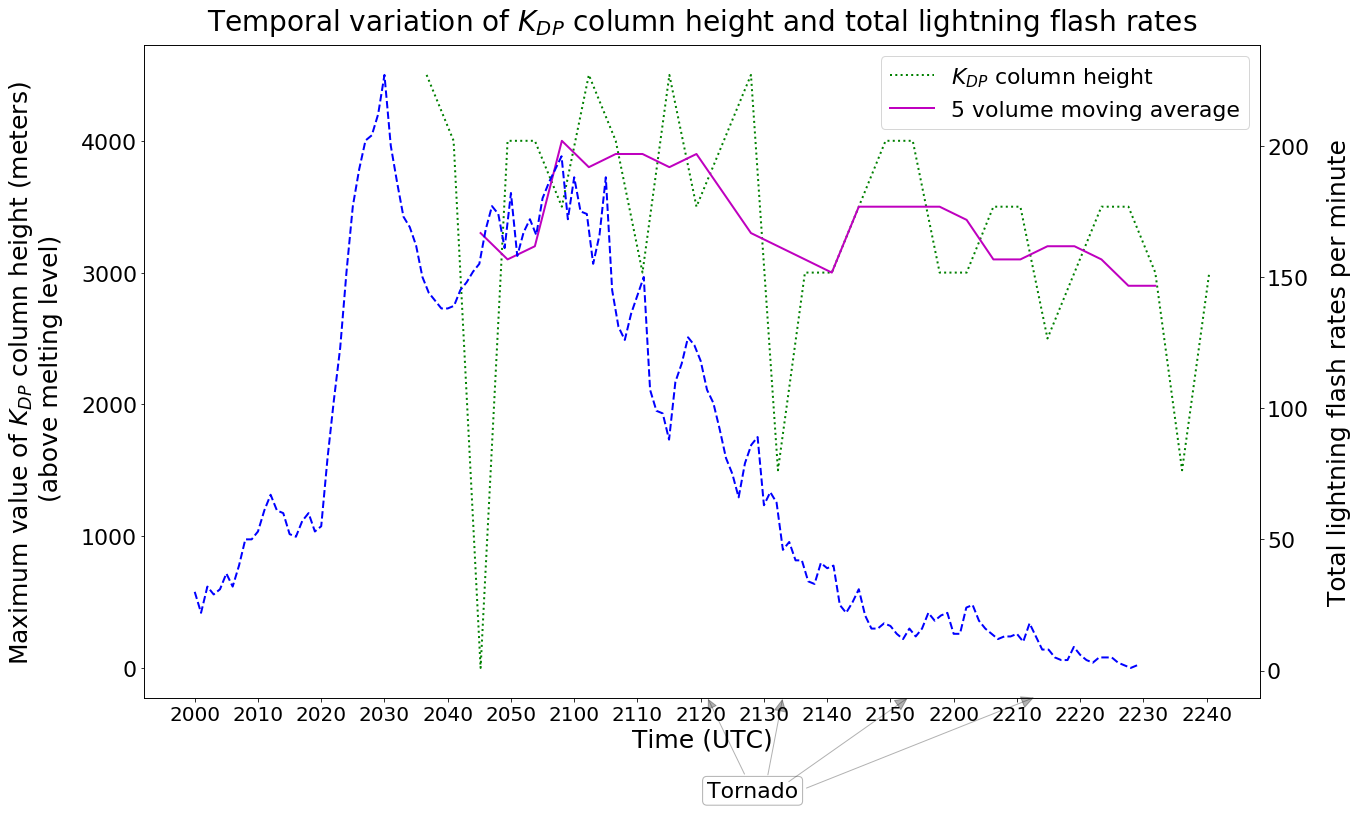

In [52]:
# Plot KDP column height time series overlaid with lightning flash rates and rolling mean

fig, ax = plt.subplots(figsize=(20, 12))
hplot1 = ax.plot_date(
    dt_tmpstmps, kdp_hght_ts, "g:", xdate=True, lw=2, label="$K_{DP}$ column height"
)
hplot2 = ax.plot_date(
    final_mvg_avg.index,
    final_mvg_avg_KTLX.values,
    "m-",
    xdate=True,
    lw=2,
    label="5 volume moving average",
)
ax.set_ylabel(
    "Maximum value of $K_{DP}$ column height (meters) \n (above melting level)",
    labelpad=18,
)
ax.set_xlabel("Time (UTC)")
ax1 = ax.twinx()
ax1.plot_date(
    final_time_lma,
    lasso_data["number"].values,
    "b--",
    xdate=True,
    lw=2,
    label="total flash rate (flashes/min)",
)
ax1.set_ylabel("Total lightning flash rates per minute", labelpad=18)
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H%M"))
hplots = hplot1 + hplot2
hlabs = [plot.get_label() for plot in hplots]
ax.legend(hplots, hlabs, loc="best", fontsize=22)

plt.title(
    "Temporal variation of $K_{DP}$ column height and total lightning flash rates",
    pad=15,
)


my_annotate(
    ax1,
    "Tornado",
    xy_arr=[
        (datetime(2013, 5, 19, 21, 21, 0), -10),
        (datetime(2013, 5, 19, 21, 33, 0), -10),
        (datetime(2013, 5, 19, 21, 53, 0), -10),
        (datetime(2013, 5, 19, 22, 13, 0), -10),
    ],
    xycoords="data",
    xytext=(0, -100),
    textcoords="offset points",
    bbox=dict(boxstyle="round,pad=0.2", fc="w", alpha=0.3),
    arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=0", fc="k", alpha=0.3),
    fontsize=22,
)

plt.show()

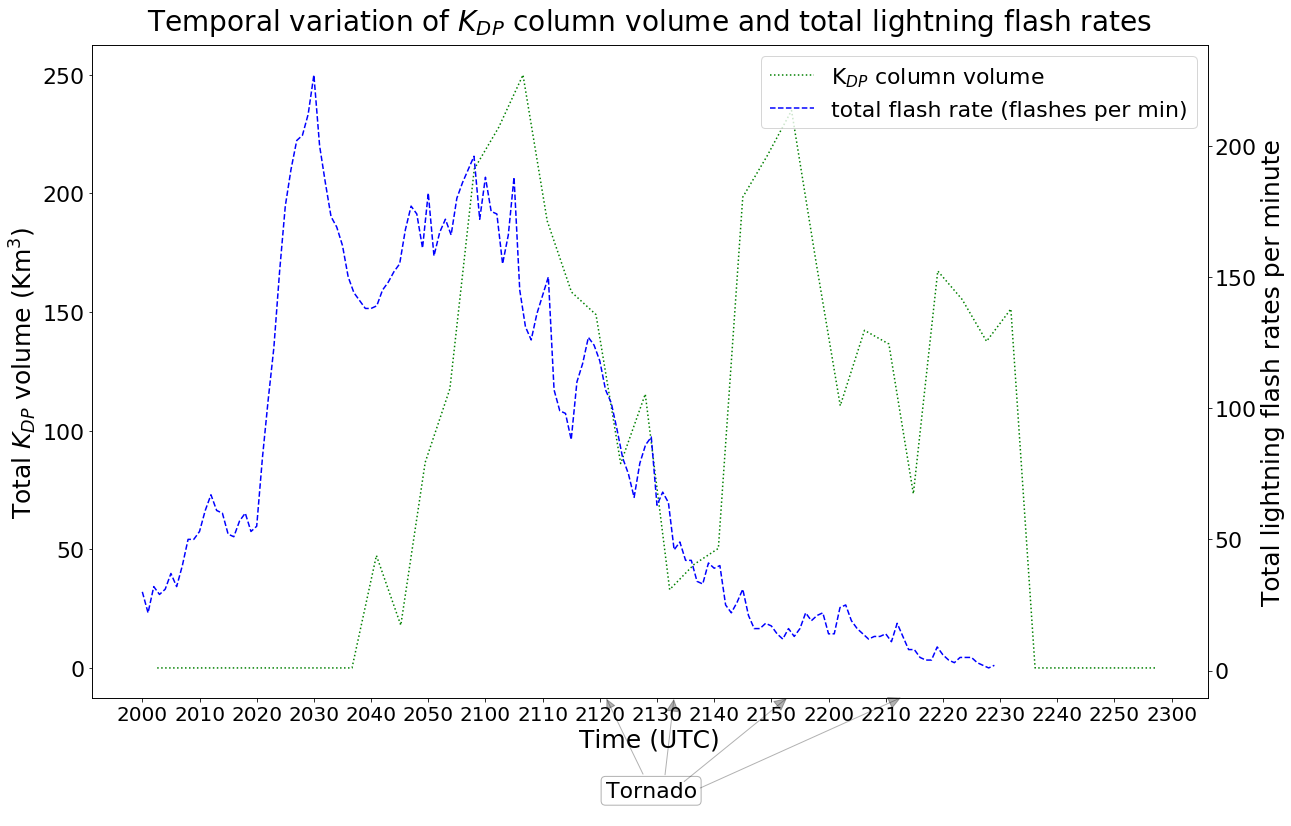

In [53]:
# Plot total KDP column volume (sum of all legit KDP objects at a time step) time series overlaid with lightning flash rates

fig, ax = plt.subplots(figsize=(20, 12))
vplot1 = ax.plot_date(
    dt_tmpstmps,
    kdp_vol_ts_new.sum(level="time"),
    "g:",
    xdate=True,
    label="K$_{DP}$ column volume",
)
ax.set_ylabel("Total $K_{DP}$ volume (Km$^{3}$)")
ax.set_xlabel("Time (UTC)")
ax1 = ax.twinx()
vplot2 = ax1.plot_date(
    final_time_lma,
    lasso_data["number"].values,
    "b--",
    xdate=True,
    label="total flash rate (flashes per min)",
)
ax1.set_ylabel("Total lightning flash rates per minute")
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H%M"))
vplots = vplot1 + vplot2
vlabs = [plot.get_label() for plot in vplots]
ax.legend(vplots, vlabs, loc="upper right",fontsize=22)
plt.title(
    "Temporal variation of $K_{DP}$ column volume and total lightning flash rates",
    pad=15,
)

my_annotate(
    ax1,
    "Tornado",
    xy_arr=[
        (datetime(2013, 5, 19, 21, 21, 0), -10),
        (datetime(2013, 5, 19, 21, 33, 0), -10),
        (datetime(2013, 5, 19, 21, 53, 0), -10),
        (datetime(2013, 5, 19, 22, 13, 0), -10),
    ],
    xycoords="data",
    xytext=(0, -100),
    textcoords="offset points",
    bbox=dict(boxstyle="round,pad=0.2", fc="w", alpha=0.3),
    arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=0", fc="k", alpha=0.3),
    fontsize=22,
)


plt.show()

In [54]:
# correlation between kdp vol total and lightning flash rates

kdp_vol_tsc = kdp_vol_ts_new.copy()
kdp_vol_tsc.columns = [""]

r_pearson_vol = kdp_vol_tsc.sum(level="time").corrwith(
    resampled_lma, axis=0, method="spearman"
)
rho_spearman_vol = kdp_vol_tsc.sum(level="time").corrwith(
    resampled_lma, axis=0, method="pearson"
)

print(
    f"Pearson correlation coefficient for kdp volume and lightning flash rates is {r_pearson_vol[0]}"
)
print(
    f"Spearman correlation coefficient for kdp volume and lightning flash rates is {rho_spearman_vol[0]}"
)

Pearson correlation coefficient for kdp volume and lightning flash rates is 0.11285269992507369
Spearman correlation coefficient for kdp volume and lightning flash rates is 0.07736889414854796


In [55]:
kdp_vol_tsc.sum(level="time").corrwith(
    resampled_lma, axis=0, method="spearman"
)

    0.112853
dtype: float64

In [56]:
# calculate Spearman corr coefficient till 2130 UTC only to avoid that peak later

kdp_vol_tsc.sum(level="time")[0:22].corrwith(
    resampled_lma[0:22], axis=0, method="spearman"
)

    0.378481
dtype: float64

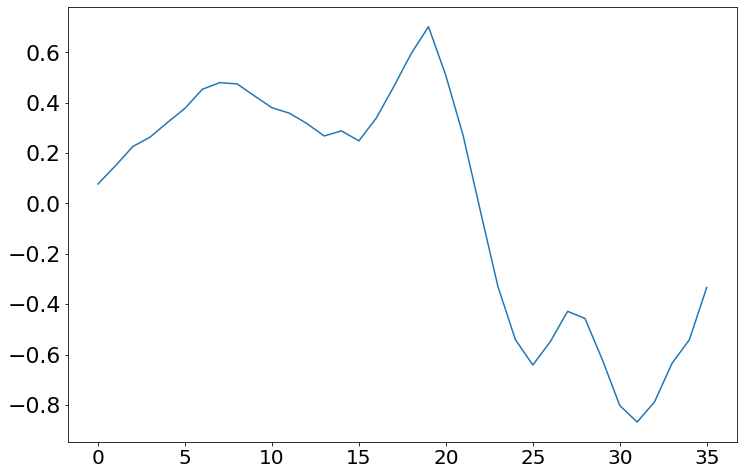

In [57]:
lagged_corr_kdp = [
    crosscorr(kdp_vol_tsc.sum(level="time"), resampled_lma, lag=i)
    for i in range(len(resampled_lma))
]

plt.plot(lagged_corr_kdp)

In [58]:
lagged_corr_kdp = np.asarray(
    lagged_corr_kdp
)  # convert lagged_corr_zdr from list to numpy array
max_corr_kdp_t = np.nanargmax(
    lagged_corr_kdp
)  # calculate the index at which the array lagged_corr_zdr attains maxima
t_kdp_corr_max = dt_tmpstmps[
    max_corr_kdp_t
]  # time corresponding to zdr_col_volume and lightning flash rates  cross correlation being maximum

delay_kdp_corr = t_kdp_corr_max - dt_tmpstmps[0]
delay_kdp_corr.total_seconds() / 3600  # total delay in hours

1.3508333333333333

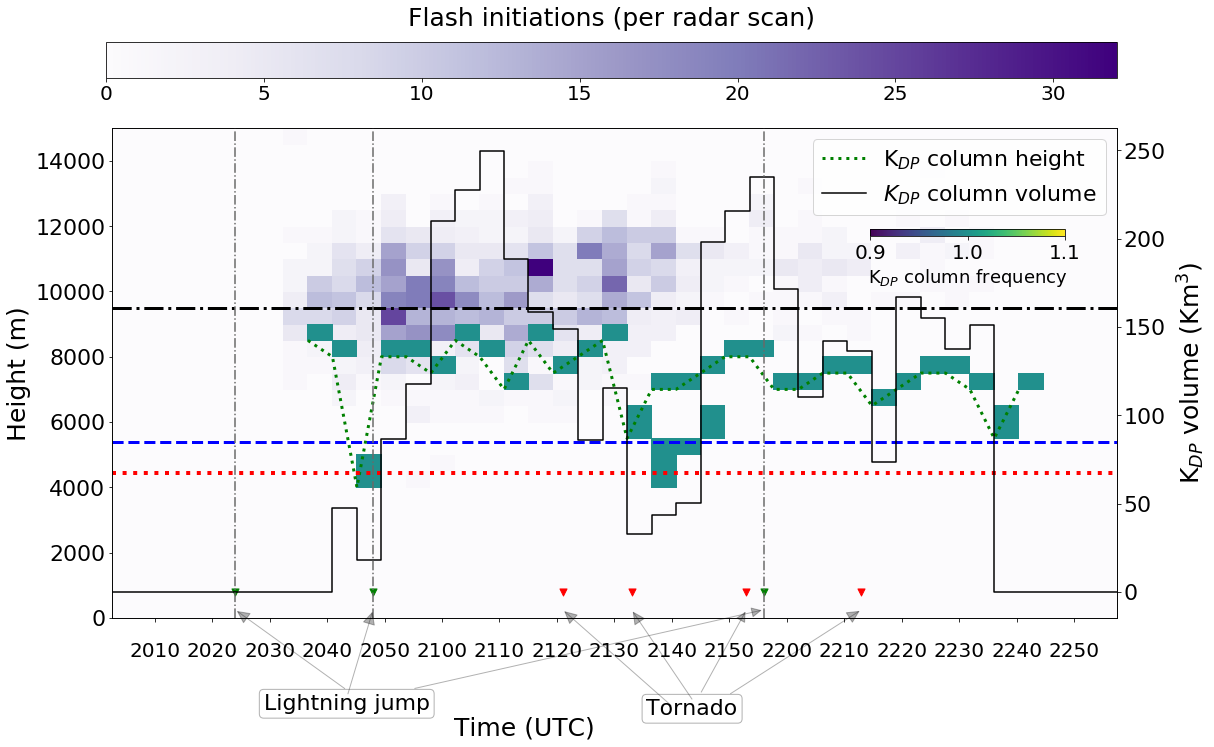

In [60]:
# Manually verified kdp columns and their aggragated volumes for each time step are plotted (if multiple kdp objects present)
# KDP column is plotted only for the tallest column at that instance in time
# KDP area is aggregated at each z-level for all time steps if multiple kdp objects are present

base_height = 4000  # this adds 4000 to the kdp column height calculated above so that the overlay of kdp_col_hght looks better


def my_annotate(
    ax, s, xy_arr=[], *args, **kwargs
):  # code taken from https://stackoverflow.com/a/14545981/12538451
    ans = []
    an = ax.annotate(s, xy_arr[0], *args, **kwargs)
    ans.append(an)
    d = {}
    try:
        d["xycoords"] = kwargs["xycoords"]
    except KeyError:
        pass
    try:
        d["arrowprops"] = kwargs["arrowprops"]
    except KeyError:
        pass
    for xy in xy_arr[1:]:
        an = ax.annotate(s, xy, alpha=0.0, xytext=(0, 0), textcoords=an, **d)
        ans.append(an)
    return ans


fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0])
mappable = ax.pcolormesh(
    ini_df.columns.values, ini_df.index.values, ini_df, cmap="Purples"
)  # plot flash initiations at each z-level as a pcolormesh in subplot 1
plot1 = ax.plot_date(
    dt_tmpstmps,
    kdp_col_df.max(level="scan") + base_height,
    "g:",
    xdate=True,
    lw=3,
    label="K$_{DP}$ column height",
)  # plot kdp column heights in subplot 1
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H%M"))
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax.set_ylabel("Height (m)")
ax.set_xlabel("Time (UTC)", labelpad=45,)
ax.xaxis.set_label_coords(0.41, -0.2)

ax.legend()
ax.tick_params(axis="x", which="major", pad=20)
ax1 = ax.twinx()
with pd.plotting.plot_params.use("x_compat", True):
    plot2 = kdp_vol_ts_new.sum(level="time").plot(
        drawstyle="steps-post", color="k", ax=ax1, rot=0
    )  # step line plot for kdp volume in subplot 1
ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H%M"))
ax1.set_ylabel("K$_{DP}$ volume (Km$^{3}$)", rotation=90, labelpad=10)
cbaxes = fig.add_axes([0.12, 0.95, 0.78, 0.05])
cbar = fig.colorbar(mappable, pad=0.15, orientation="horizontal", cax=cbaxes)
cbar.set_label("Flash initiations (per radar scan)", fontsize=25, labelpad=-97)
ax1.get_legend().remove()
plots = plot1 + plot2.get_lines()
labs = [plot.get_label() for plot in plots]
ax.legend(plots, labs, loc=0, fontsize=22)

plot6 = ax.pcolormesh(
    kdp_freq_final.index.values,
    kdp_freq_final.columns.values + base_height,
    kdp_freq_final.values.astype(float).transpose(),
)  # pcolormesh plot of kdp col height in subplot 3
cbaxes_ = fig.add_axes([0.71, 0.73, 0.15, 0.01])
cbar_ = fig.colorbar(plot6, pad=0.15, orientation="horizontal", cax=cbaxes_)
cbar_.set_label("K$_{DP}$ column frequency", fontsize=18)
# plt.setp(ax1.get_xticklabels(), visible=False)
# plt.setp(ax.get_xticklabels(), visible=False)

# add tornado reports on x-axis
ax1.scatter(datetime(2013, 5, 19, 21, 21, 0), 0, marker="v", s=50, c="r")
ax1.scatter(datetime(2013, 5, 19, 21, 33, 0), 0, marker="v", s=50, c="r")
ax1.scatter(datetime(2013, 5, 19, 21, 53, 0), 0, marker="v", s=50, c="r")
ax1.scatter(datetime(2013, 5, 19, 22, 13, 0), 0, marker="v", s=50, c="r")

# add lightning jump times
ax1.scatter(datetime(2013, 5, 19, 20, 24, 0), 0, marker="v", s=50, c="g")
ax1.scatter(datetime(2013, 5, 19, 20, 48, 0), 0, marker="v", s=50, c="g")
ax1.scatter(datetime(2013, 5, 19, 21, 56, 0), 0, marker="v", s=50, c="g")

ax1.axvline(datetime(2013, 5, 19, 20, 24, 0), linestyle="-.", color="dimgrey")
ax1.axvline(datetime(2013, 5, 19, 20, 48, 0), linestyle="-.", color="dimgrey")
ax1.axvline(datetime(2013, 5, 19, 21, 56, 0), linestyle="-.", color="dimgrey")

my_annotate(
    ax1,
    "Tornado",
    xy_arr=[
        (datetime(2013, 5, 19, 21, 53, 0), -10),
        (datetime(2013, 5, 19, 22, 13, 0), -10),
        (datetime(2013, 5, 19, 21, 33, 0), -10),
        (datetime(2013, 5, 19, 21, 21, 0), -10),
    ],
    xycoords="data",
    xytext=(-100, -105),
    textcoords="offset points",
    bbox=dict(boxstyle="round,pad=0.2", fc="w", alpha=0.3),
    arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=0", fc="k", alpha=0.3),
    fontsize=22,
)

my_annotate(
    ax1,
    "Lightning jump",
    xy_arr=[
        (datetime(2013, 5, 19, 21, 56, 0), -10),
        (datetime(2013, 5, 19, 20, 24, 0), -10),
        (datetime(2013, 5, 19, 20, 48, 0), -10),
    ],
    xycoords="data",
    xytext=(-500, -100),
    textcoords="offset points",
    bbox=dict(boxstyle="round,pad=0.2", fc="w", alpha=0.3),
    arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=0", fc="k", alpha=0.3),
    fontsize=22,
)

ax.axhline(y=4436,linestyle='dotted',linewidth=4,c='r',label='0$^{\circ}$C')
ax.axhline(y=5376,linestyle='dashed',linewidth=3,c='b',label='-10$^{\circ}$C')
ax.axhline(y=9490,linestyle='dashdot',linewidth=3,c='k',label='-40$^{\circ}$C')

# ax.legend()
# plt.savefig('/Users/ms/Desktop/mount/May_19_2013_all_stuff/plots_LMA_May19_2013/manuscript_figures/individual_plots_for_panel_figures/zdr_kdp_vol_init_per_radar_scan/KDP_col_vol_initiations_per_radar_scan1.png',
#            dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
# tt = kdp_col_df.max(level="scan")
# tt.loc[[dt_tmpstmps[8],dt_tmpstmps[36],dt_tmpstmps[37]],'kdp_col_height'] = np.nan

# yy = kdp_freq_final
# yy.loc[dt_tmpstmps[8],dt_tmpstmps[36],dt_tmpstmps[37]] = np.nan

# zz = ini_df
# zz[dt_tmpstmps[7:9]] = np.nan
# zz[dt_tmpstmps[36:38]] = np.nan

NameError: name 'zz' is not defined

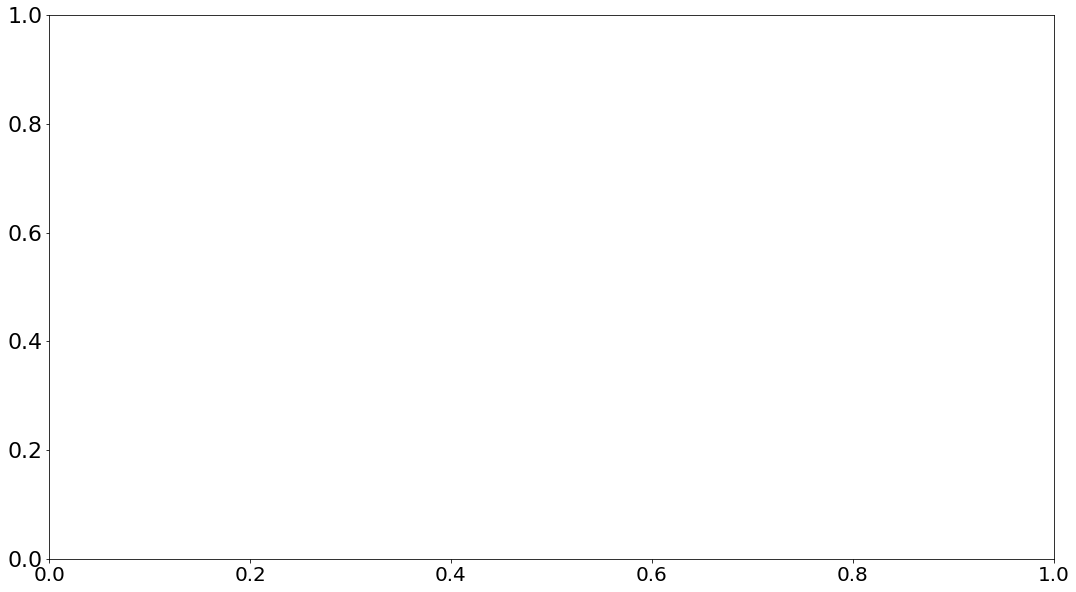

In [81]:
# Manually verified kdp columns and their aggragated volumes for each time step are plotted (if multiple kdp objects present)
# KDP column is plotted only for the tallest column at that instance in time
# KDP area is aggregated at each z-level for all time steps if multiple kdp objects are present

base_height = 4000  # this adds 4000 to the kdp column height calculated above so that the overlay of kdp_col_hght looks better


def my_annotate(
    ax, s, xy_arr=[], *args, **kwargs
):  # code taken from https://stackoverflow.com/a/14545981/12538451
    ans = []
    an = ax.annotate(s, xy_arr[0], *args, **kwargs)
    ans.append(an)
    d = {}
    try:
        d["xycoords"] = kwargs["xycoords"]
    except KeyError:
        pass
    try:
        d["arrowprops"] = kwargs["arrowprops"]
    except KeyError:
        pass
    for xy in xy_arr[1:]:
        an = ax.annotate(s, xy, alpha=0.0, xytext=(0, 0), textcoords=an, **d)
        ans.append(an)
    return ans


fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0])
mappable = ax.pcolormesh(
    zz.columns.values, ini_df.index.values, ini_df, cmap="Purples"
)  # plot flash initiations at each z-level as a pcolormesh in subplot 1
plot1 = ax.plot_date(
    dt_tmpstmps,
    tt + base_height,
    "g:",
    xdate=True,
    lw=3,
    label="K$_{DP}$ column height",
)  # plot kdp column heights in subplot 1
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H%M"))
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax.set_ylabel("Height (m)")
ax.set_xlabel("Time (UTC)", labelpad=42)
ax.legend()
ax.tick_params(axis="x", which="major", pad=20)
ax1 = ax.twinx()
with pd.plotting.plot_params.use("x_compat", True):
    plot2 = kdp_vol_ts_new.sum(level="time").plot(
        drawstyle="steps-post", color="k", ax=ax1, rot=0
    )  # step line plot for kdp volume in subplot 1
ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H%M"))
ax1.set_ylabel("K$_{DP}$ volume (Km$^{3}$)", rotation=90, labelpad=10)
cbaxes = fig.add_axes([0.12, 0.95, 0.78, 0.05])
cbar = fig.colorbar(mappable, pad=0.15, orientation="horizontal", cax=cbaxes)
cbar.set_label("Flash initiations (per radar scan)", fontsize=25, labelpad=-97)
ax1.get_legend().remove()
plots = plot1 + plot2.get_lines()
labs = [plot.get_label() for plot in plots]
ax.legend(plots, labs, loc=0, fontsize=22)

plot6 = ax.pcolormesh(
    yy.index.values,
    yy.columns.values + base_height,
    yy.values.astype(float).transpose(),
)  # pcolormesh plot of kdp col height in subplot 3
cbaxes_ = fig.add_axes([0.71, 0.73, 0.15, 0.01])
cbar_ = fig.colorbar(plot6, pad=0.15, orientation="horizontal", cax=cbaxes_)
cbar_.set_label("K$_{DP}$ column frequency", fontsize=18)
# plt.setp(ax1.get_xticklabels(), visible=False)
# plt.setp(ax.get_xticklabels(), visible=False)

# add tornado reports on x-axis
ax1.scatter(datetime(2013, 5, 19, 21, 21, 0), -0.5, marker="v", s=50, c="r")
ax1.scatter(datetime(2013, 5, 19, 21, 33, 0), -0.5, marker="v", s=50, c="r")
ax1.scatter(datetime(2013, 5, 19, 21, 53, 0), -0.5, marker="v", s=50, c="r")
ax1.scatter(datetime(2013, 5, 19, 22, 13, 0), -0.5, marker="v", s=50, c="r")

# add lightning jump times
ax1.scatter(datetime(2013, 5, 19, 20, 24, 0), -0.5, marker="v", s=50, c="g")
ax1.scatter(datetime(2013, 5, 19, 20, 48, 0), -0.5, marker="v", s=50, c="g")

ax1.axvline(datetime(2013, 5, 19, 20, 24, 0), linestyle="-.", color="dimgrey")
ax1.axvline(datetime(2013, 5, 19, 20, 48, 0), linestyle="-.", color="dimgrey")

my_annotate(
    ax1,
    "Tornado",
    xy_arr=[
        (datetime(2013, 5, 19, 21, 21, 0), 0),
        (datetime(2013, 5, 19, 21, 33, 0), 0),
        (datetime(2013, 5, 19, 21, 53, 0), 0),
        (datetime(2013, 5, 19, 22, 13, 0), 0),
    ],
    xycoords="data",
    xytext=(0, -99),
    textcoords="offset points",
    bbox=dict(boxstyle="round,pad=0.2", fc="w", alpha=0.3),
    arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=0", fc="k", alpha=0.3),
    fontsize=22,
)

my_annotate(
    ax1,
    "Lightning jump",
    xy_arr=[
        (datetime(2013, 5, 19, 20, 24, 0), 0),
        (datetime(2013, 5, 19, 20, 48, 0), 0),
    ],
    xycoords="data",
    xytext=(0, -100),
    textcoords="offset points",
    bbox=dict(boxstyle="round,pad=0.2", fc="w", alpha=0.3),
    arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=0", fc="k", alpha=0.3),
    fontsize=22,
)

plt.show()